# Rolling Forecast

## Executive summary

In this project, we built two models to forecast rolling 6-month revenue for two hotels correspondently. 

We cleaned the data by removing duplicate rows and rows with negative and extreme values, as well as incomplete data records. We developed a function to convert daily revenue to monthly revenue and observed annual seasonality in the time series.

We compared two strategies for multi-step forecasting and developed four models, which we evaluated on the validation dataset. The direct multi-step forecasting strategy showed the best performance, with 
- a MAE of 141.54K and a 95% confidence interval of 21.51K—315.84K for City Hotel, and
- a MAE of 114.23K and a 95% confidence interval of 5.39K—466.84K for Resort Hotel.

## Table of contents

- [Introduction](#Introduction)
- [Terminology](#Terminology)
- [Code Setup](#Code-setup)
- [Load data](#Load-data)
- [Data quality analysis](#Data-quality-analysis)
- [Revenue stream](#Revenue-stream)
- [Forecasting](#Forecasting)
- [Model Performance evaluation](#Model-Performance-evaluation)
- [Conclusion](#Conclusio)

## Introduction

### Project Objective

We want to predict the next 6 months rolling revenue for each of the two hotels based on their booking transaction history.

The solution should work at any time of the year and provide a forecast.

Results should include:
- Explanation of the approach used
- Model accuracy
- Confidence interval

### Approach

#### ML task to be solved

Given the hotel's revenue stream, we want to predict the next 6 revenue steps in the future. This problem can be viewed as multi-step time series forecasting.

There are at least four commonly used strategies for making multi-step forecasts. They are:

1. Direct Multi-step Forecast strategy that involves developing a separate model for each forecast time step.
1. Recursive Multi-step Forecast strategy that involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.
1. Direct-Recursive Hybrid Multi-step Forecast strategies that combines direct and recursive strategies.
1. Multiple Output Forecast strategy involves developing one model that is capable of predicting the entire forecast sequence in a one-shot manner.

Also, we have two time series, one for "City Hotel" and the other for "Resort Hotel". This problem can be thought of as multi-series forecasting, where two or more time series are modeled together using a single model. Also several strategies can be distinguished:

1. Independent time-series models involves developing a separate model for each time series.
1. No multivariate time series, when a single model is trained, but each time series remains independent of the others. 
1. Multivariate time series in which all series are modeled taking into account the fact that each time series depends not only on its past values but also on the past values of other series.

#### Model Accuracy Metrics

We forecast monthly revenue as a continuous value. Thus, we must apply regression metrics to evaluate the performance of the model.

In this work, we choose the Mean Absolute Error (MAE) metric because it is easy to interpret and insensitive to outliers, which provides an even measure of how well the model is performing.

To measure the uncertainty of our MAE estimation, we calculate an empirical 95% confidence interval by repeatedly evaluating the model on the validation dataset and taking the 2.5th and 97.5th percentiles of the resulting distribution of MAE values. This gives us a range within which the true MAE is likely to fall 95% of the time.

### Main stages

The work contains the following main stages.

- Setup code to load Python packages, and define constants and functions.
- Data quality analysis to identify issues such as duplicates, unwanted entries, etc.
- Revenue stream calculation to convert booking transaction data into a monthly revenue stream.
- Forecasting to build multiple predictive models based on different strategies.
- Model evaluation to evaluate and compare the performance of models on a validation dataset.

## Data field	Definition

The dataset given for the task contains the following fields.

1. `hotel` — Hotel (H1 = Resort Hotel or H2 = City Hotel)
1. `is_canceled` — Value indicating if the booking was canceled (1) or not (0)
1. `lead_time` — Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
1. `arrival_date_year` — Year of arrival date
1. `arrival_date_month` — Month of arrival date
1. `arrival_date_week_number` — Week number of year for arrival date
1. `arrival_date_day_of_month` — Day of arrival date
1. `stays_in_weekend_nights` — Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
1. `stays_in_week_nights` — Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
1. `adults` — Number of adults
1. `children` — Number of children
1. `babies` — Number of babies
1. `meal` — Type of meal booked. Categories are presented in standard hospitality meal packages: 
    - Undefined/SC – no meal package; 
    - BB – Bed & Breakfast; 
    - HB – Half board (breakfast and one other meal – usually dinner); 
    - FB – Full board (breakfast, lunch and dinner)
1. `country` — Country of origin. Categories are represented in the ISO 3155–3:2013 format
1. `market_segment` — Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
1. `distribution_channel` — Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
1. `is_repeated_guest` — Value indicating if the booking name was from a repeated guest (1) or not (0)
1. `previous_cancellations` — Number of previous bookings that were cancelled by the customer prior to the current booking
1. `previous_bookings_not_canceled` — Number of previous bookings not cancelled by the customer prior to the current booking
1. `reserved_room_type` — Code of room type reserved. Code is presented instead of designation for anonymity reasons.
1. `assigned_room_type` — Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.
1. `booking_changes` — Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
1. `deposit_type` — Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: 
    - No Deposit – no deposit was made; 
    - Non Refund – a deposit was made in the value of the total stay cost; 
    - Refundable – a deposit was made with a value under the total cost of stay.
1. `agent` — ID of the travel agency that made the booking
1. `company` — ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
1. `days_in_waiting_list` — Number of days the booking was in the waiting list before it was confirmed to the customer
1. `customer_type` — Type of booking, assuming one of four categories: 
    - Contract - when the booking has an allotment or other type of contract associated to it; 
    - Group – when the booking is associated to a group; 
    - Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; 
    - Transient-party – when the booking is transient, but is associated to at least other transient booking
1. `adr` — Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
1. `required_car_parking_spaces` — Number of car parking spaces required by the customer
1. `total_of_special_requests` — Number of special requests made by the customer (e.g. twin bed or high floor)
1. `reservation_status` — Reservation last status, assuming one of three categories: 
    - Canceled – booking was canceled by the customer; 
    - Check-Out – customer has checked in but already departed; 
    - No-Show – customer did not check-in and did inform the hotel of the reason why
1. `reservation_status_date` — Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus

## Terminology

Here we would like to establish common ground in the definitions of terms.

### Rolling Forecast

A rolling forecast is a type of financial model that predicts the future performance of a business over a continuous period, based on historical data. Unlike static budgets that forecast the future for a fixed time frame, e.g., January to December, a rolling forecast is regularly updated throughout the year to reflect any changes.

Source [CFI](https://corporatefinanceinstitute.com/resources/accounting/rolling-forecast/)

![Rolling Forecast](https://docs.oracle.com/cd/E57185_01/AGOHP/images/graphics/rolling_forecast_12_month.gif)

Source [Oracle](https://docs.oracle.com/cd/E57185_01/AGOHP/ch06s04s06s01.html)


### Average Daily Rate

In data field definition Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

$$
\text{ADR} = \frac{\sum_{i=1}^{n}\text{Lodging Transaction}_i}{\text{Number of Staying Nights}}
$$

Note this difinition differs from another industry perfomance indicatior ADR that tells a lodging company how much they make per room on average in a given day. Here Average Daily Rate as defined by dividing  the total rooms revenue at your hotel by the total occupied rooms. 

$$
\text{ADR} = \frac{\text{Rooms Revenue Earned}}{\text{Number of Rooms Sold}}
$$

Source: [Investopedia](https://www.investopedia.com/terms/a/average-daily-rate.asp)

In this work, we adhere to the first definition of ADR as the sum of all accommodation transactions divided by the total number of nights of stay.

### Revenue recognition


According to [Accounting Standard Codification (ASC) 606](https://revgurus.com/knowledge-center-asc-606-hotel-industry/) Hotel amortizes revenue from room rentals and allied servives equally over period of stay of the customer, i.e. on each day till he/she check-out. 

Therefore, revenue is recognized for the month or months that include the period of the customer's stay. Assume that a cancellation deposit is recognized in the month in which the last booking status was set.

### Revenue calculation

Based on the definition of ADR in the dataset, we assume that booking revenue is the product of ADR and total nights of stay. In case of cancellation, the revenue generated by a booking works the same way as a product of ADR and total nights if they were a deposit or not and if it is refundable or not. 

$$
\begin{equation}
    \text{Booking revenue} = 
    \begin{cases}
        \text{checked-out } & 
            \text{ADR } \times \text{ Number of nights } \\
        \text{canceled with non-refundable deposit }  & 
            \text{ADR } \times \text{ Number of nights } \\
        \text{otherwise } & 
            0
    \end{cases}
\end{equation}
$$

In accordance with the codification of Accounting Standard 606, the Hotel amortizes revenue from room rentals and allied servives equally during the period of the client's stay, i.e. for each day before his or her departure or for each night staying. In case of cancellation, there are no actual staying so we recognize the entire amount of the refundable deposit on the day the status changes to Cancelled.


$$
\begin{equation}
    \text{Booking Revenue}_{month} = 
    \begin{cases}
        \text{checked-out }  & 
            \text{ADR } \times \text{ Number of nights}_{month}, \text{night}_{month} \in \text{month} \\
        \text{canceled with non-refundable deposit }  & 
            \text{ADR } \times \text{ Number of nights}, \text{cancellation_date} \in \text{month} \\
        \text{otherwise } & 
            0
    \end{cases}
\end{equation}
$$


 

## Code setup

This section loads python packages and defines constants and functions that will be used in the work.

### Load packages

In [1]:
import pandas as pd
import numpy as np
from yaml import dump as yaml_dump
from os import path as os_path

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import Ridge

[Skforecast](https://github.com/JoaquinAmatRodrigo/skforecast/) is a python library that eases using scikit-learn regressors as multi-step forecasters.

In [4]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.utils import save_forecaster

Local packages

In [5]:
from src import (eda as e, data as d, model as m, utils as u)

### Constant definitions

In [6]:
N_STEPS = 6       # number of steps to forecast
N_TESTS = 5       # number of model perfomance tests on validation data
N_LAGS  = 2       # number of lags used as predictors

HOTELS_LIST = ['City Hotel', 'Resort Hotel']
RANDOM_STATE = 230220

MODELS_PATH = 'models'

## Load data

In [7]:
data = pd.read_excel('data/hotel_bookings.xlsx', sheet_name=0)
data.shape

(119390, 32)

Loaded dataset contains about 119K observations and 32 fields.

## Data quality analysis

We start with obervation of general dataset structure.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

The dataset contains fields that match the data definition. The data types correspond to the meaning of the field. Most fields do not have explicit missing values.

Booking date is represented by separate fields day, month and year.

The total number of nights of stay is represented by fields for weeks and weekends nights.

### Duplicates

Let's check if there are duplicate rows in the dataset.

In [9]:
data.duplicated().sum()

31994

There are duplicate rows in the dataset. We consider it unlikely that two bookings with the same parameters will be placed on the same day, so we remove duplicates.

In [10]:
data = data.drop_duplicates()
data.shape

(87396, 32)

87K rows left in the dataset now.

### Narrow down the fields

Since the ADR is based on the sum of all lodging transactions, we can assume that it reflects all properties of the booking. Thus, we can only focus on the following fields, at least in the first iteration of the study:
- `arrival_date`, 
- `reservation_status_date`, 
- `hotel`, 
- `adr`, 
- `total_nights`,
- `is_canceled`, 
- `deposit_type`, 
- `reservation_status`


At first, Let's transform arrival date to date-time format.

In [11]:
data['arrival_date'] = data.apply(
    lambda raw: d.build_datetime(raw.arrival_date_year, raw.arrival_date_month,
                                 raw.arrival_date_day_of_month),
    axis=1)

And calculate total nights of stay.

In [12]:
data['total_nights'] = data.stays_in_weekend_nights + data.stays_in_week_nights

Now we can drop irrelevant fields.

In [13]:
df = data[[
    'arrival_date', 'reservation_status_date', 'hotel', 'adr', 'total_nights',
    'is_canceled', 'deposit_type', 'reservation_status'
]].copy()

del(data)

### General Overview

In [14]:
df.head()

,arrival_date,reservation_status_date,hotel,adr,total_nights,is_canceled,deposit_type,reservation_status
0,2015-07-01,2015-07-01,Resort Hotel,0.0,0,0,No Deposit,Check-Out
1,2015-07-01,2015-07-01,Resort Hotel,0.0,0,0,No Deposit,Check-Out
2,2015-07-01,2015-07-02,Resort Hotel,75.0,1,0,No Deposit,Check-Out
3,2015-07-01,2015-07-02,Resort Hotel,75.0,1,0,No Deposit,Check-Out
4,2015-07-01,2015-07-03,Resort Hotel,98.0,2,0,No Deposit,Check-Out


The values are ok.

In [15]:
df.describe()

,adr,total_nights,is_canceled
count,87396.000000,87396.000000,87396.000000
mean,106.337246,3.630658,0.274898
std,55.013953,2.763449,0.446466
min,-6.380000,0.000000,0.000000
25%,72.000000,2.000000,0.000000
50%,98.100000,3.000000,0.000000
75%,134.000000,5.000000,1.000000
max,5400.000000,69.000000,1.000000


ADR ranges from -6.4 to 5400. At the same time, for half of the observations, the ADR range is from 69 to 126. Negative and maximum values seem to be an error.

Total_nights has a maximum value of 69, and the 75th percentile is only 4.

27% of the bookings in the dataset are cancelled. 

In [16]:
df.hotel.value_counts()

City Hotel      53428
Resort Hotel    33968
Name: hotel, dtype: int64

Dataset has only two hotels as indicated in the task.

In [17]:
df.deposit_type.value_counts()

No Deposit    86251
Non Refund     1038
Refundable      107
Name: deposit_type, dtype: int64

Values of `deposit_type` field are ok too.

### ADR

Let's analyze ADR in detail.

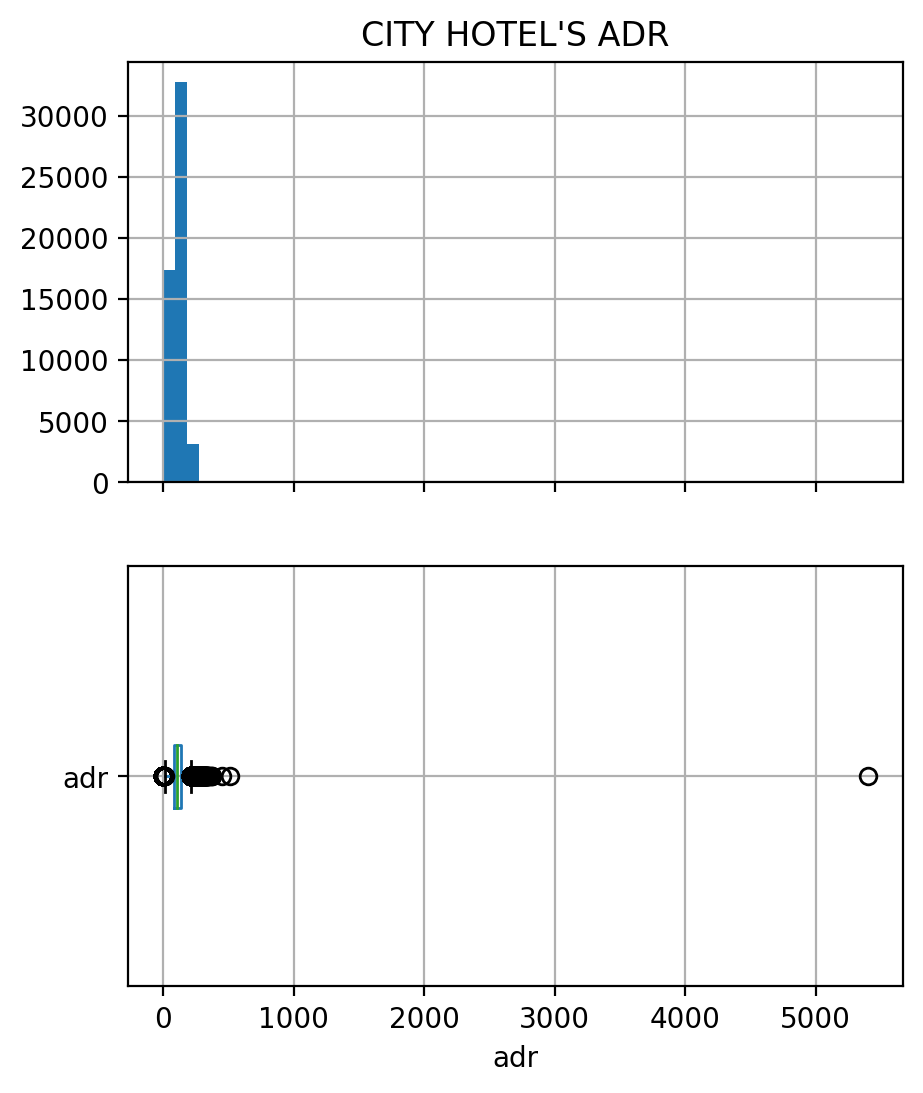

In [18]:
e.draw_hist_and_boxplot(data=df[df.hotel == 'City Hotel'],
                        column='adr',
                        title='City Hotel\'s ADR'.upper())

An ADR above 5000 is an outlier and we consider it an unwanted entry. So let's remove this line.

In [19]:
df = df[df.adr < 1000]
df.shape

(87395, 8)

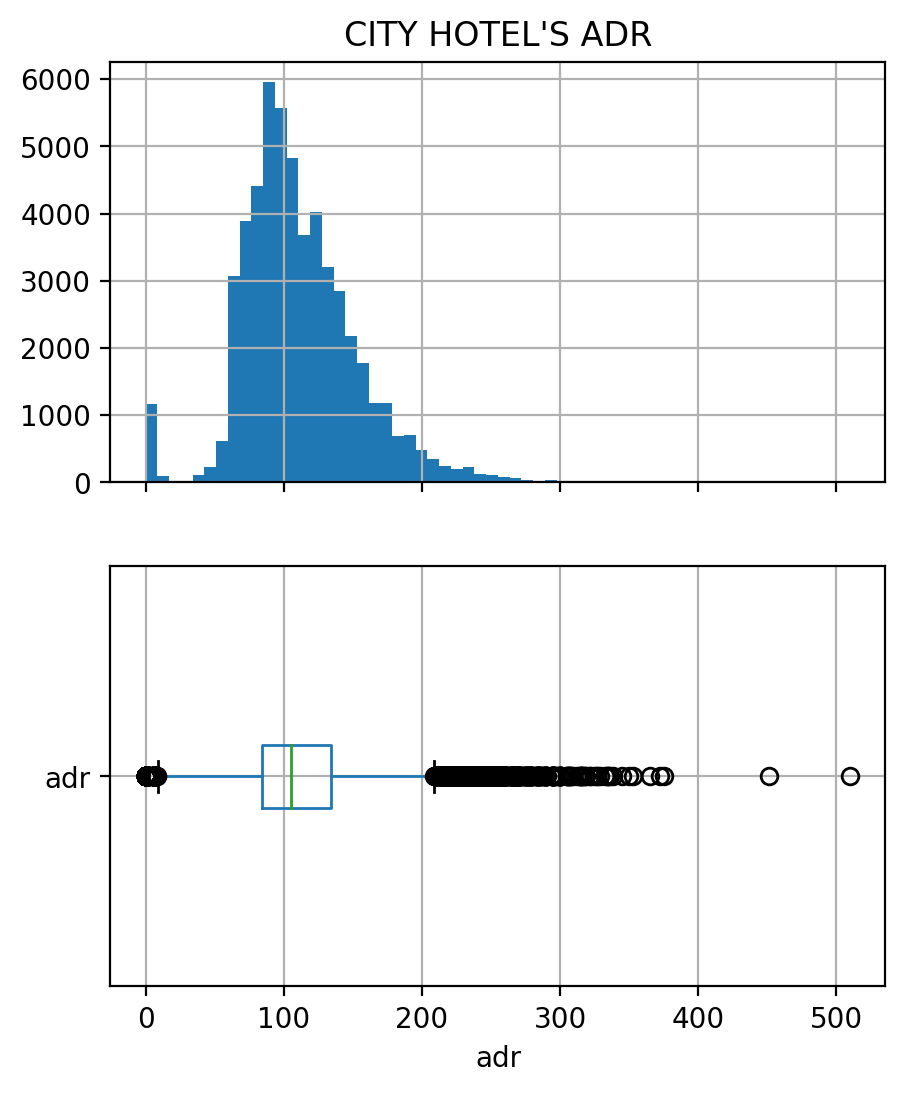

In [20]:
e.draw_hist_and_boxplot(data=df[df.hotel == 'City Hotel'],
                        column='adr',
                        title='City Hotel\'s ADR'.upper())

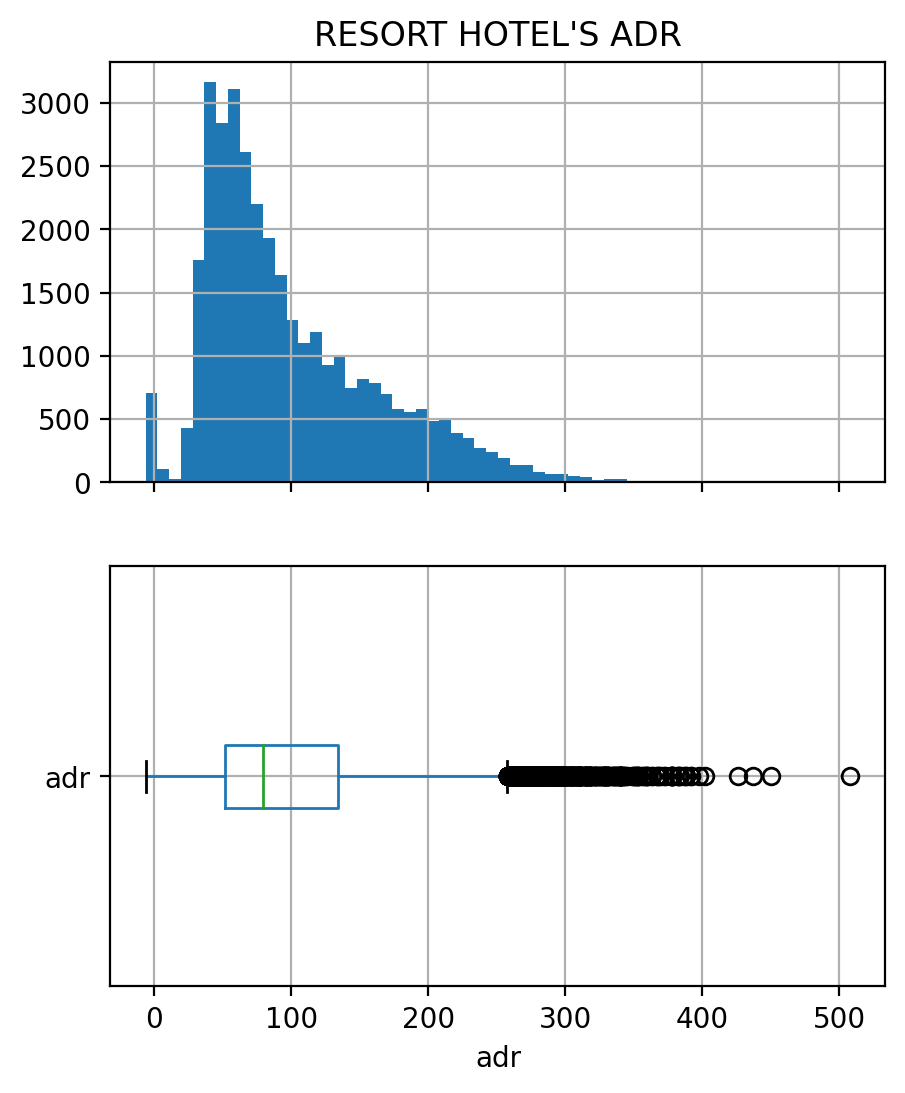

In [21]:
e.draw_hist_and_boxplot(data=df[df.hotel == 'Resort Hotel'],
                        column='adr',
                        title='Resort Hotel\'s ADR'.upper())

On the histogram, we see an outlier in the zero region. Resort Hotel has negative ADR values. Since transactions with zero ADRs do not affect revenue, and negative values are considered an error, we will leave only rows with positive ADR values in the dataset.

In [22]:
df = df[df.adr > 0]
df.shape

(85616, 8)

### Total nights

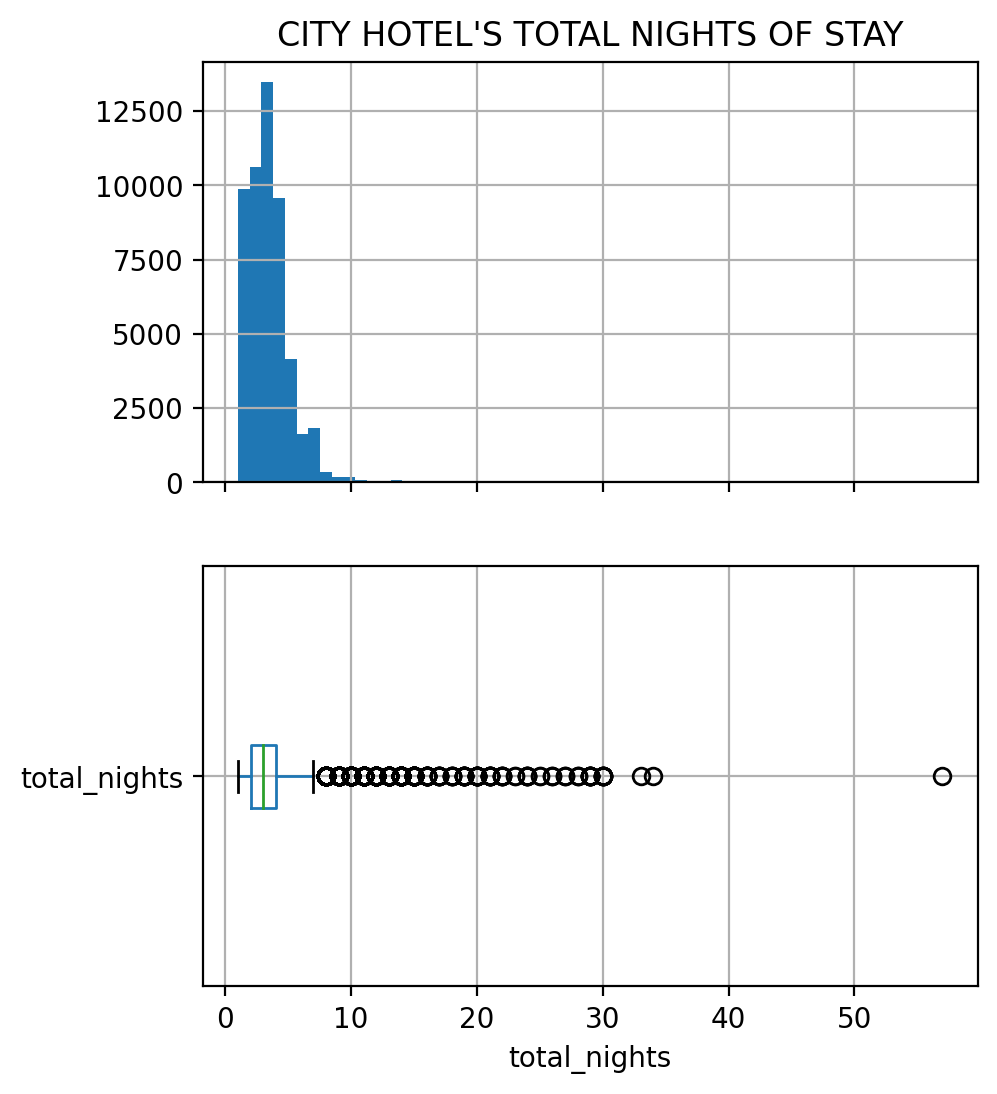

In [23]:
e.draw_hist_and_boxplot(data=df[df.hotel == 'City Hotel'],
                        column='total_nights',
                        title='City Hotel\'s total nights of stay'.upper())

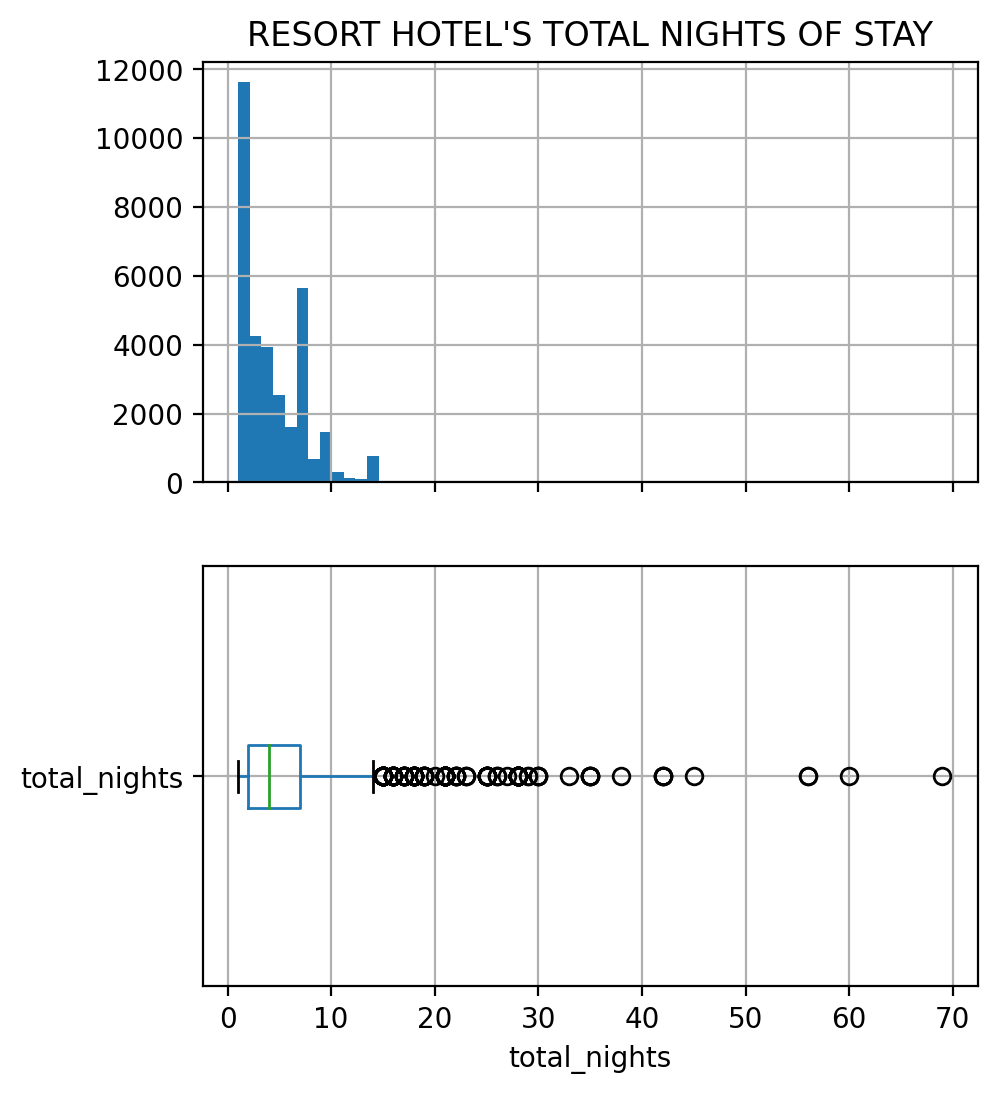

In [24]:
e.draw_hist_and_boxplot(data=df[df.hotel == 'Resort Hotel'],
                        column='total_nights',
                        title='Resort Hotel\'s total nights of stay'.upper())

Even though we clearly see outliers, we can imagine that some rare guests stay for a couple of months. We believe these entries are not an error records.

### Number of transactions

Let's observe total number of transactions by their status over time.

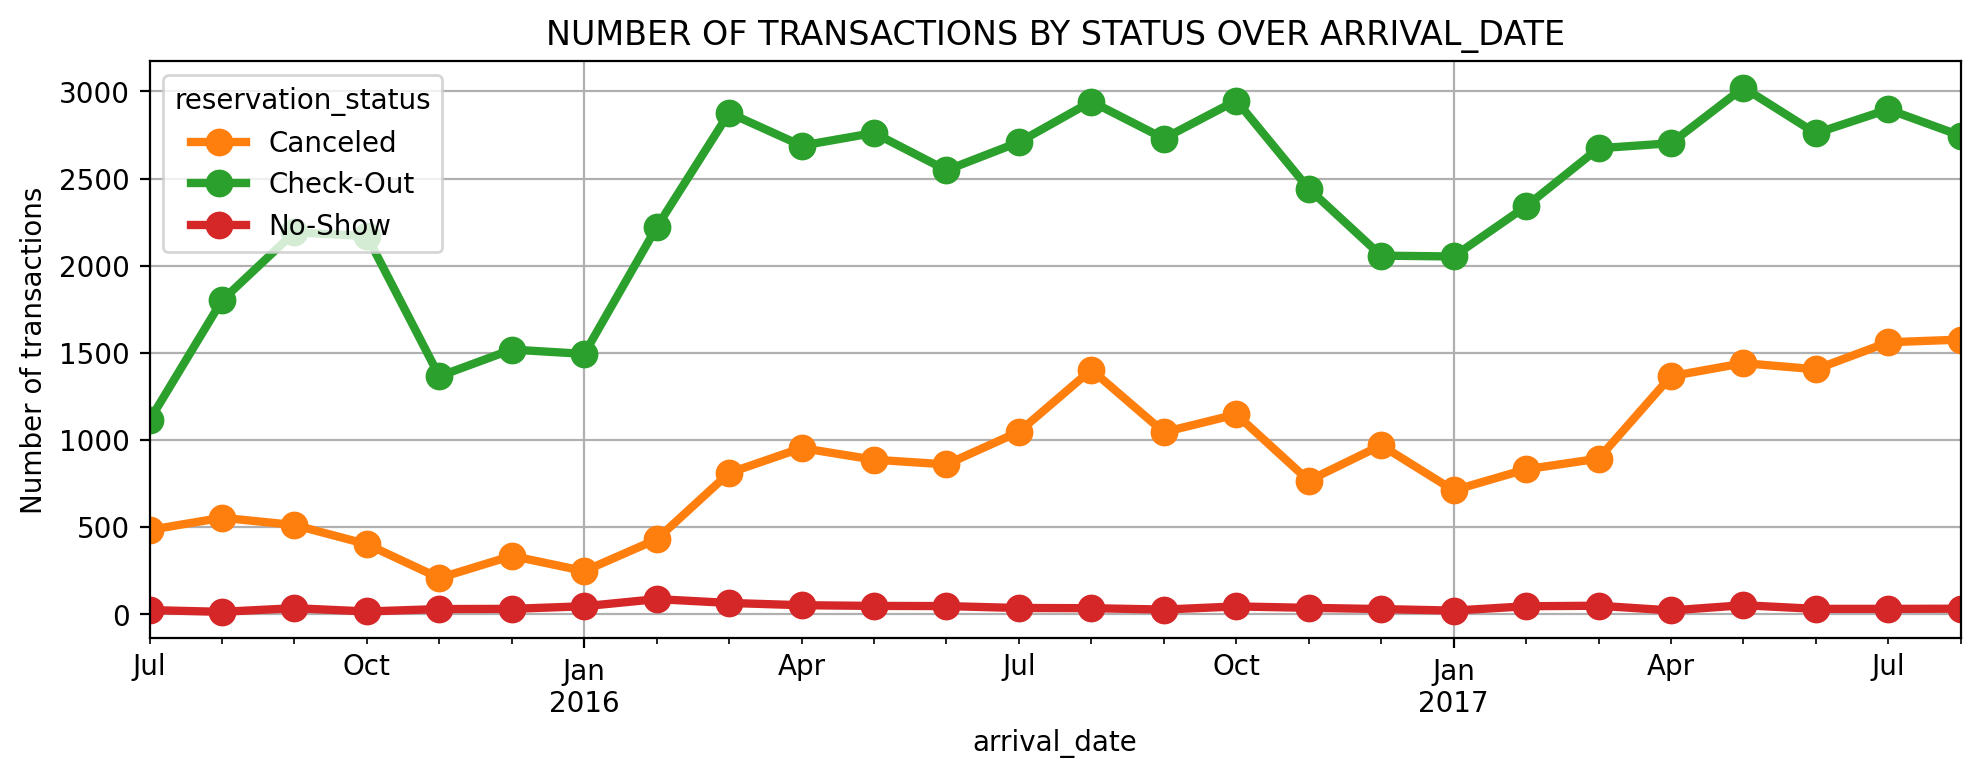

In [25]:
e.draw_num_transactions(
    data=df,
    index='arrival_date',
    column='reservation_status',
    title='Number of transactions by status over arrival_date')

We observe the time interval from July 2015 to August 2017. Bookings with a "No Check" status are quite rare. The number of cancellations is growing. The number of check-out bookings in July and August 2015 is significantly lower than in the same months of 2016. We believe these periods contain incomplete data.

Let's group transactions by `reservation_status_date`.

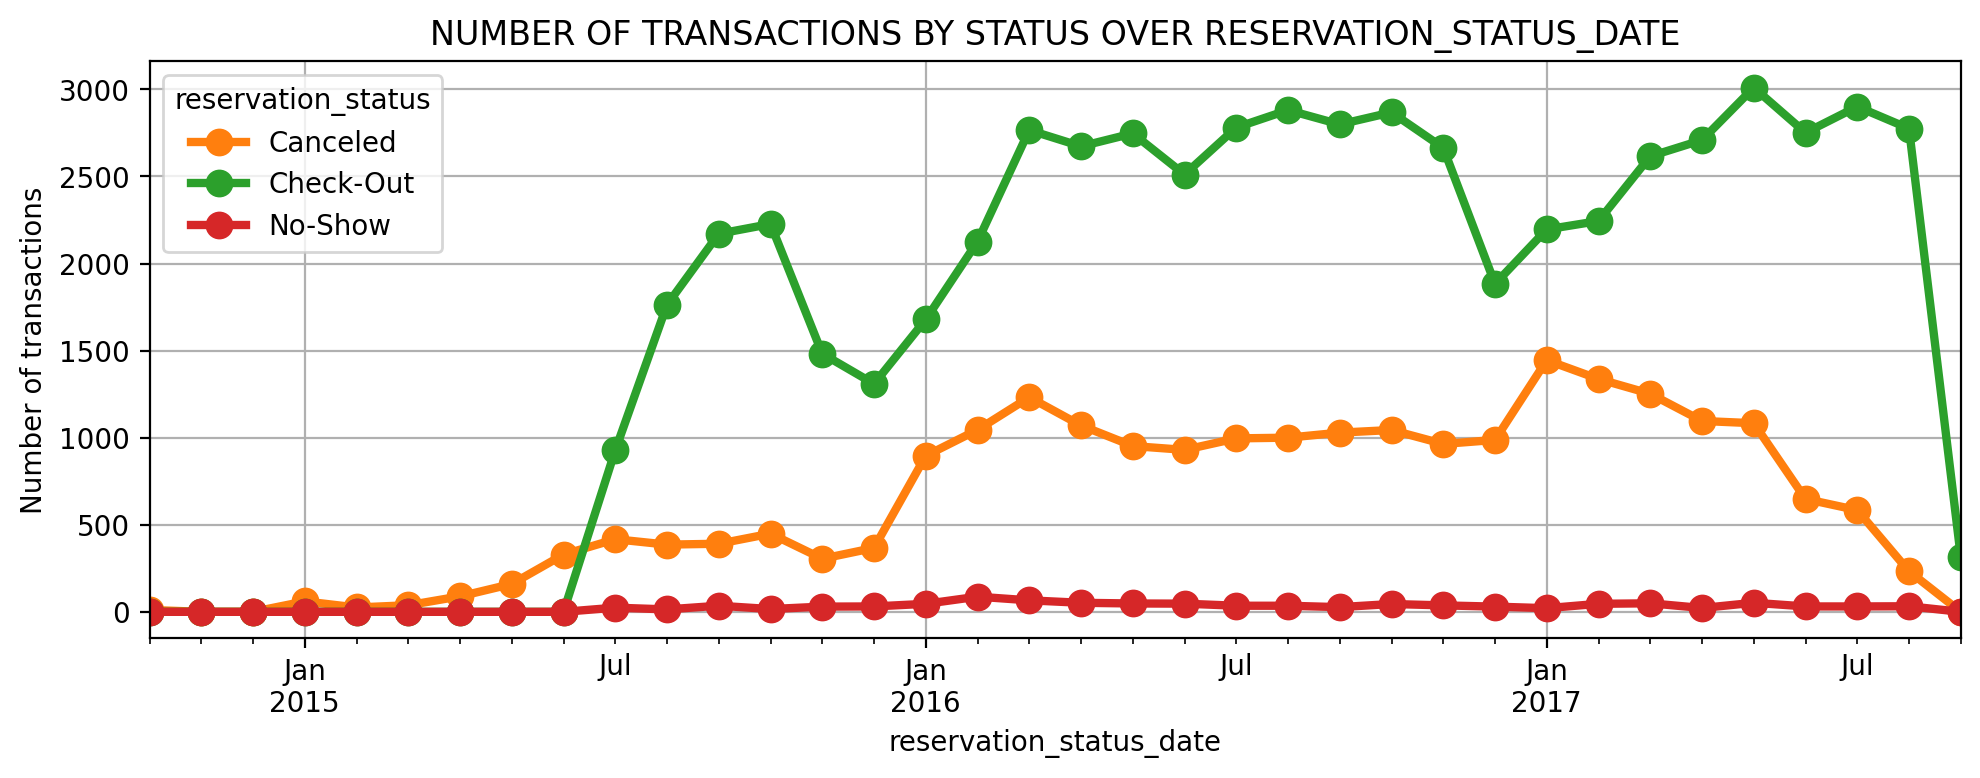

In [26]:
e.draw_num_transactions(
    data=df,
    index='reservation_status_date',
    column='reservation_status',
    title='Number of transactions by status over reservation_status_date')

The range of `reservation_status_date` values is wider due to canceled reservations. Note that there are entries in the data outside the period of arrival dates if the booking was cancelled.

### Cancellation status

The dataset has two fields related to the cancellation status. Let's check what `reservation_status` values we can observe for `is_canceled` values.

In [27]:
pd.pivot_table(df, index='reservation_status', columns='is_canceled', values='hotel', aggfunc='count')

is_canceled,0,1
reservation_status,,
Canceled,NaN,22850.0
Check-Out,61777.0,NaN
No-Show,NaN,989.0


The statuses are perfect for each other.

### Time series range

Finally, let's check if the time series ranges are the same for both hotels.

In [28]:
for h in HOTELS_LIST:
    print(f"{h} arrivals\tfrom {df.arrival_date.min().date()} to {df.arrival_date.max().date()}")

City Hotel arrivals	from 2015-07-01 to 2017-08-31
Resort Hotel arrivals	from 2015-07-01 to 2017-08-31


Everything looks good.

### Conclusion

We investigated the quality of the data and found the following issues:
- there were duplicate rows in the data set, which we removed,
- there were rows with a negative and zero value of the ADR field, as well as with an extreme value above 5000, which we deleted,
- the number of records for the first two months of the time series is significantly less than the corresponding period in the future, so we consider that July and August 2015 have incomplete data records,
- no other errors were observed,
- time series for both hotels have the same range from July 1st, 2015 August 31st, 2017.

## Revenue Stream

We first calculate the daily revenue using the `calculate_daily_revenue_stream` function for each hotel. We need to know the first and last days of the time series and the total number of days in it.

In [29]:
START_DATE = df.arrival_date.min()
END_DATE = df.arrival_date.max()
NUMBER_OF_DAYS = (df.arrival_date.max() - START_DATE).days + 1

START_DATE.date(), END_DATE.date(), NUMBER_OF_DAYS

(datetime.date(2015, 7, 1), datetime.date(2017, 8, 31), 793)

### Test revenue function

We compare revenue calculated by `calculate_daily_revenue_stream` function with manually calculated revenue to be sure the function works correctly. 

For this we need dataset containing booking that generates revenue only and `reservation_status_date` within arrival dates interval.

In [30]:
pure_df = (
    df[
        df.reservation_status_date.between(START_DATE, END_DATE)
        & (((df.is_canceled == 1) & df.deposit_type == 'Non Refund')
        | (df.is_canceled == 0))
    ]
)

Total revenue is a sum of product ADR and the total nights of stay.

In [31]:
print(f"Total revenue: {(pure_df.adr * pure_df.total_nights).sum():.2f}")

Total revenue: 22709375.14


Calculate revenue with function that recognizes booking's revenue to the corresponding dates.

In [32]:
revenue_stream = d.calculate_daily_revenue_stream(data=pure_df,
                                                  n_days=NUMBER_OF_DAYS,
                                                  start_date=START_DATE)

In [33]:
print(f"Total revenue: {revenue_stream.sum():.2f}")

Total revenue: 22709375.14


We get the same result in both cases. Finally, let's double check this.

In [34]:
np.isclose(revenue_stream.sum(), (pure_df.adr * pure_df.total_nights).sum())

True

We prove the `calculate_daily_revenue_stream` function works correctly.

### Revenue stream for each hotel

Let's build daily revenue stram for aech hotel.

In [35]:
revenue_stream = dict()
for hotel in HOTELS_LIST:
    revenue_stream[hotel] = d.calculate_daily_revenue_stream(
        data=df[df.hotel == hotel],
        n_days=NUMBER_OF_DAYS,
        start_date=START_DATE)

In [36]:
revenue_stream = pd.DataFrame(revenue_stream,
                              index=pd.date_range(start=START_DATE,
                                                  periods=NUMBER_OF_DAYS))

In [37]:
revenue_stream.head()

,City Hotel,Resort Hotel
2015-07-01,471.00,3174.16
2015-07-02,5013.67,5931.66
2015-07-03,1121.94,7830.68
2015-07-04,827.94,10251.80
2015-07-05,514.27,11680.05


Does dataset contain rows with zero values?

In [38]:
for hotel in HOTELS_LIST:
    print(
        f'Number of rows with missing values for {hotel}:'
        f'\t{revenue_stream.loc[revenue_stream[hotel]==0, hotel].count()}'
    )

Number of rows with missing values for City Hotel:	1
Number of rows with missing values for Resort Hotel:	0


In [39]:
revenue_stream[revenue_stream['City Hotel'] == 0]

,City Hotel,Resort Hotel
2015-07-24,0.0,23638.34


We have one day of zero revenue for the City Hotel, which confirms our concerns about the incomplete data for July 2015.

Since we need to forecast monthly revenue let's resample timeseries by month by summing the daily revenue. 

In [40]:
revenue_stream = revenue_stream.resample('1M').sum()
print(revenue_stream.shape)
revenue_stream.head()

(26, 2)


,City Hotel,Resort Hotel
2015-07-31,36805.79,593209.82
2015-08-31,210799.59,825376.23
2015-09-30,445672.77,452945.92
2015-10-31,364644.97,260228.17
2015-11-30,150751.10,132981.15


We have 26 steps in two timeseries to train and test the model(s).

### Time series analysis

We have a rather short time series of only 26 months, which limits the ability to observe trends and seasonality. Thus, we can apply the 3-month moving average to explore the more general nature of the time series.

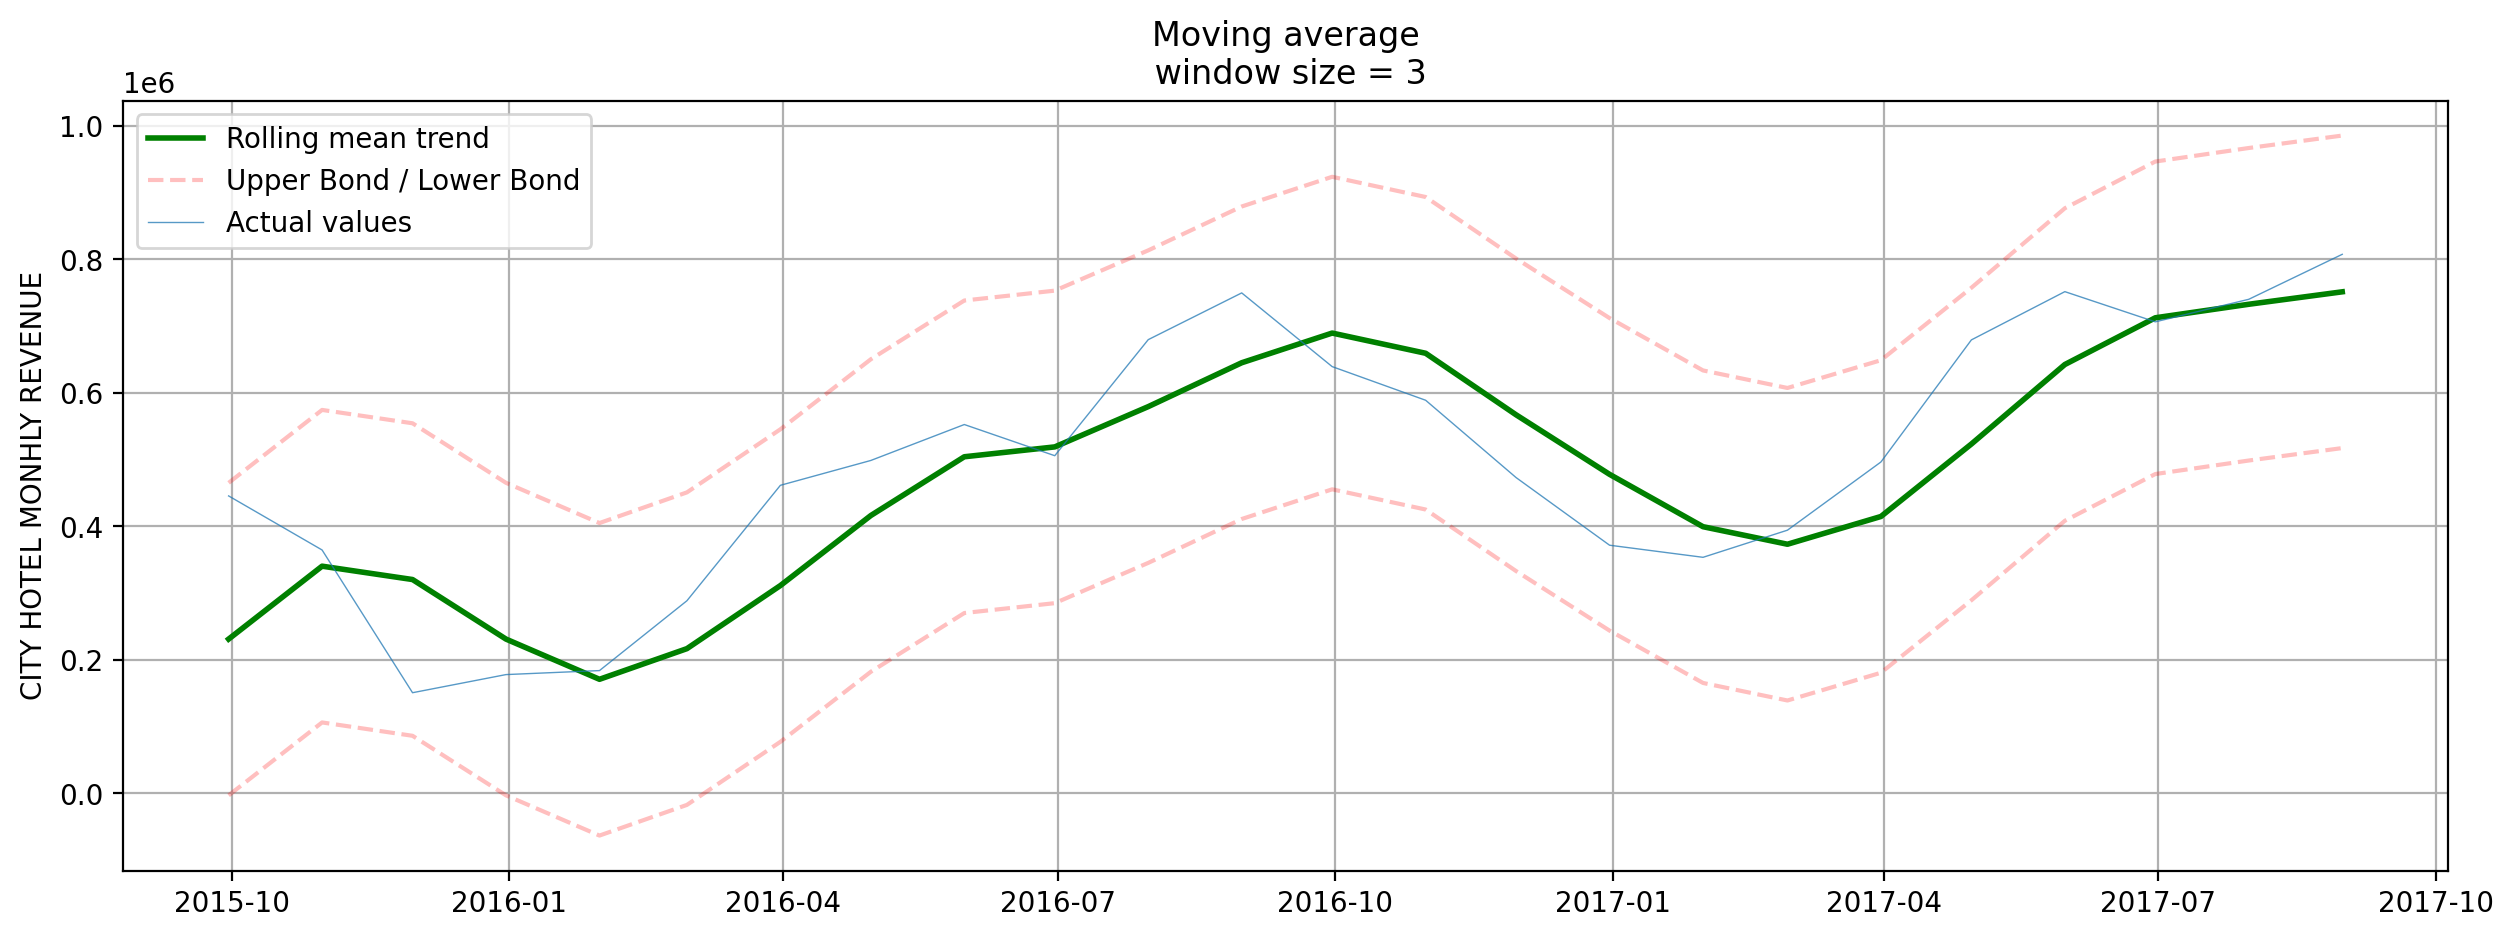

In [41]:
e.plotMovingAverage(revenue_stream.drop('Resort Hotel', axis=1),
                    3,
                    plot_intervals=True,
                    plot_anomalies=True,
                    ylabel="City Hotel Monhly Revenue".upper())

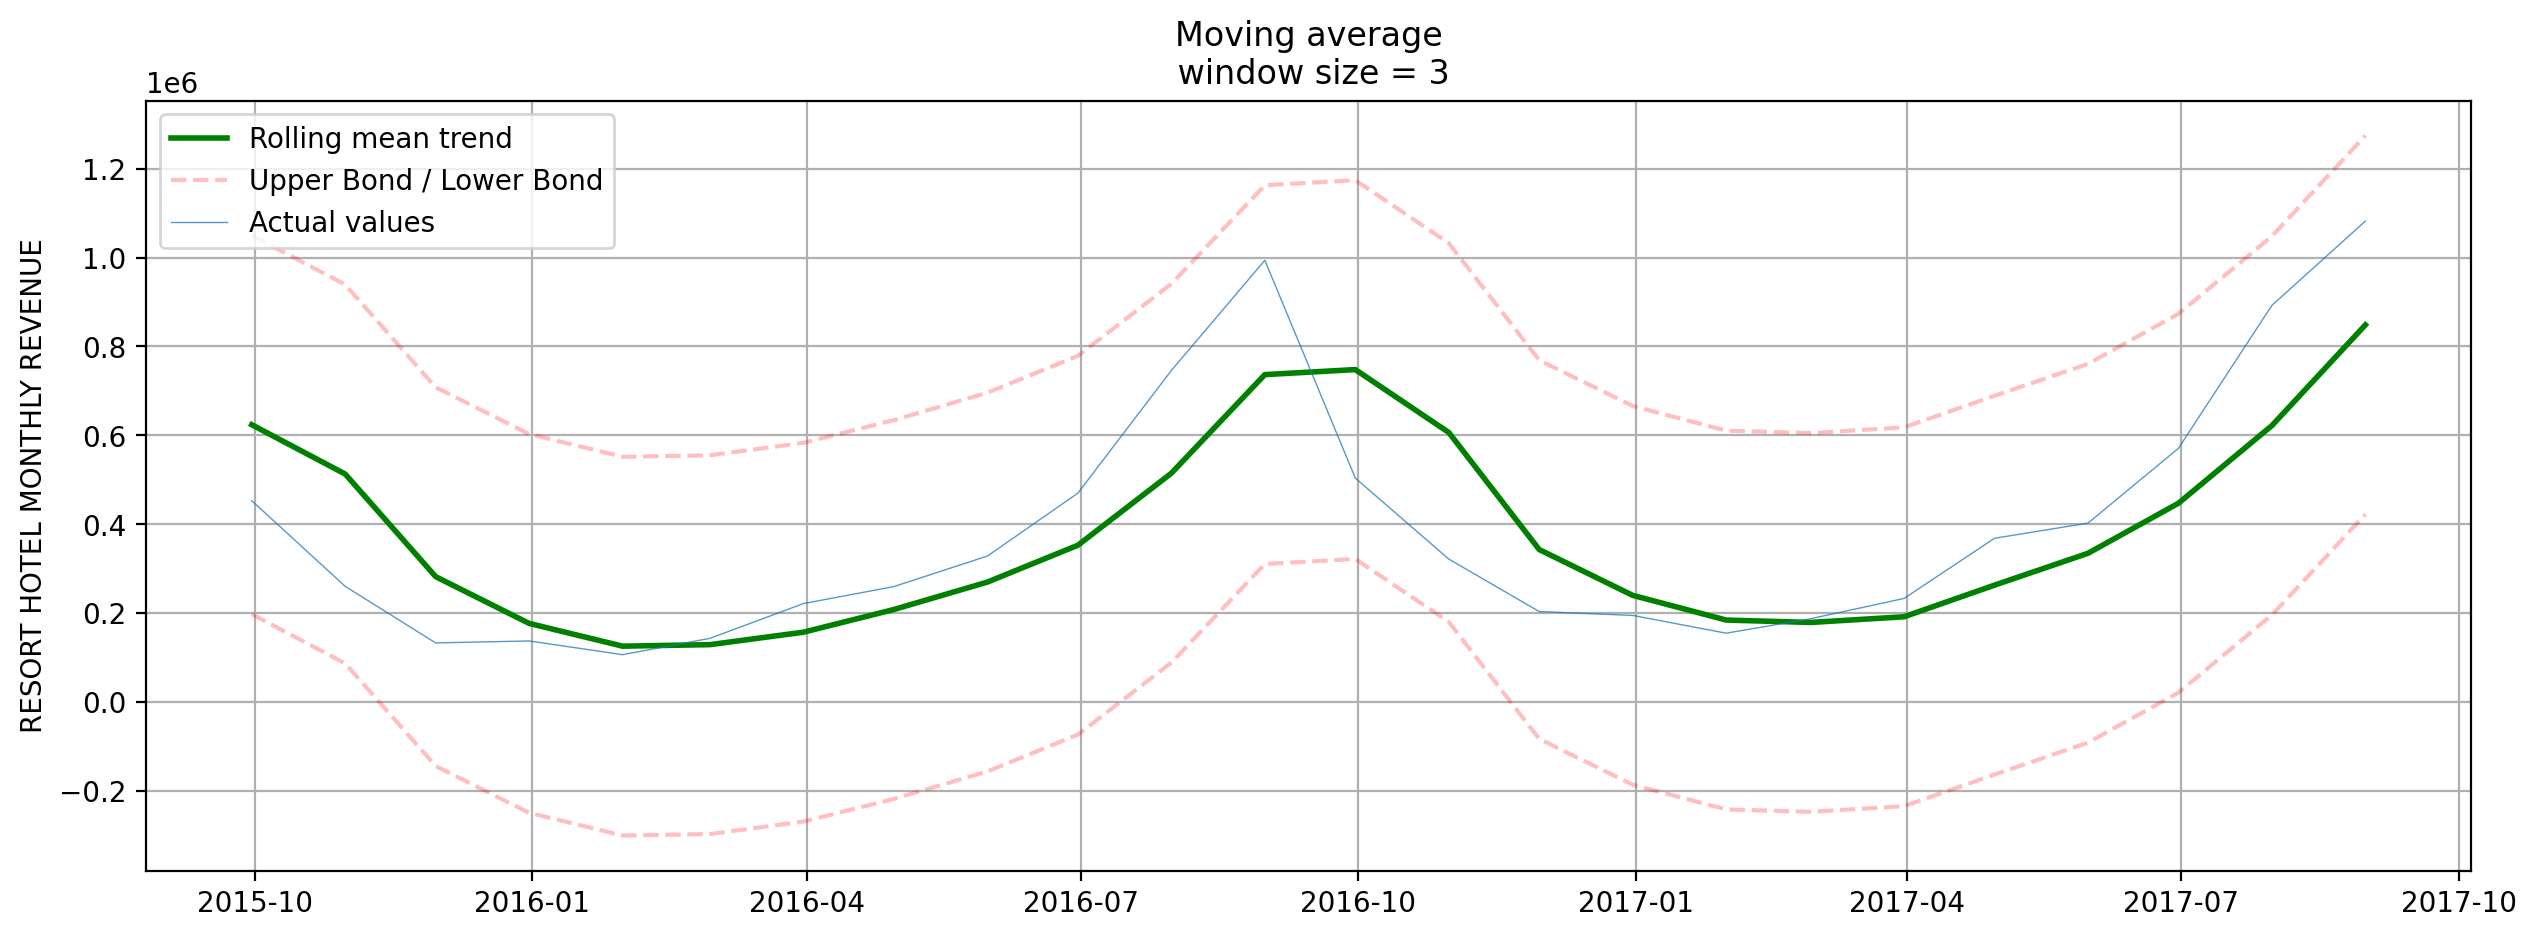

In [42]:
e.plotMovingAverage(revenue_stream.drop('City Hotel', axis=1),
                    3,
                    plot_intervals=True,
                    plot_anomalies=True,
                    ylabel="Resort Hotel Monthly Revenue".upper())

We cannot say that the time series for City Hotel is stationary and vice versa for Resort Hotel.

At the same time we obseerve annual seasonality. 

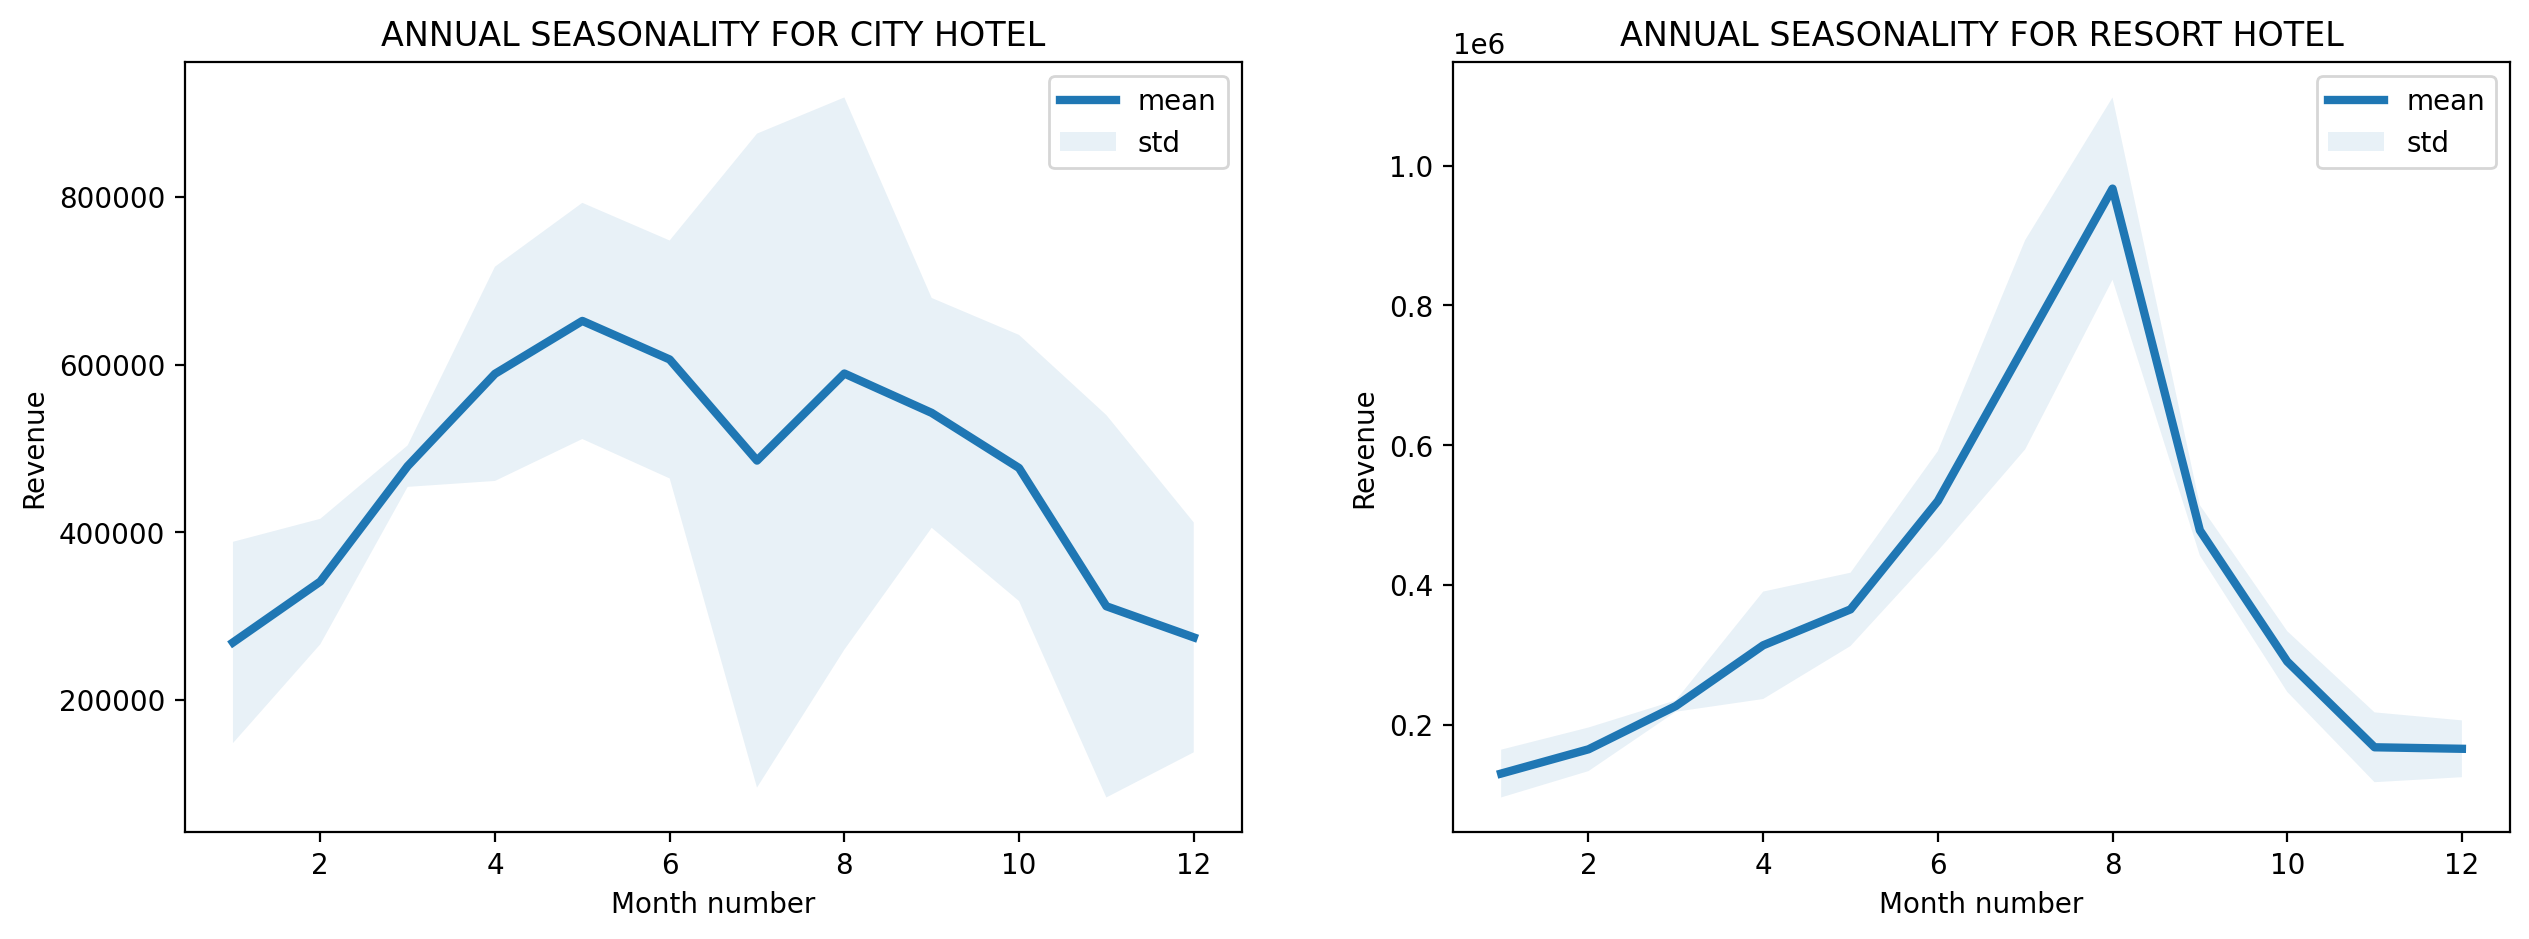

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for hotel, ax in zip(HOTELS_LIST, axes):
    to_drop = set(HOTELS_LIST) - set([hotel])
    e.draw_window_statistics(ts=revenue_stream.drop(to_drop, axis=1),
                             rule="M",
                             date_part_func=lambda x: x.index.month,
                             ax=ax,
                             xlabel="Month number",
                             title=f"Annual seasonality for {hotel}")

plt.show()

The month of the year affects income, which is especially noticeable for a resort hotel. Note also the different shape of the curves for hotels.

### Conclusions

We have defined a function to calculate and recognize daily revenue based on booking transaction history. With this function, we calculated the daily revenue stream for each hotel and converted it to monthly revenue.

We examined the monthly income time series for each hotel and confirmed the observation that the first two months of the series contain incomplete data.

We observed annual seasonality.

## Forecasting

In this work, we apply the strategy of implementing two independent models for each time series, reducing the problem of multi-series multi-step forecasting to multi-step forecasting only. 

For each hotel, we build models based on recursive multi-step forecasting and direct multi-step forecasting, and then compare all models on the validation dataset.

To build forecaters we use [Skforecast python library](https://github.com/JoaquinAmatRodrigo/skforecast/) that eases using scikit-learn regressors as multi-step forecasters.

### Exogenous variables

We have established an annual seasonality, so we add the number of months in a year as an exogenous variable to the time series.

In [44]:
revenue_stream['month_of_the_year'] = revenue_stream.index.month

### Train-validation split

We going to run `N_TESTS` experiiments on the validation dataset to evaluate models performanse. So for these tests we have to keep $n_{steps} + n_{tests} - 1$ steps in the validation dataset. 

In [45]:
validation_steps = N_STEPS + N_TESTS - 1
validation_steps

10

Since the first two steps contain incomplete data, we skip them. 

Because of the short historical timeframe in relation to the number of prediction steps required, we skip the last step of testing on the test dataset.

In [46]:
train = revenue_stream[2:-validation_steps].copy()
valid  = revenue_stream[-validation_steps:].copy()

print(f"Train dates       : {train.index.min()} ... {train.index.max()}  (n={len(train)})")
print(f"Validation dates  : {valid.index.min()} ... {valid.index.max()}  (n={len(valid)})")


Train dates       : 2015-09-30 00:00:00 ... 2016-10-31 00:00:00  (n=14)
Validation dates  : 2016-11-30 00:00:00 ... 2017-08-31 00:00:00  (n=10)


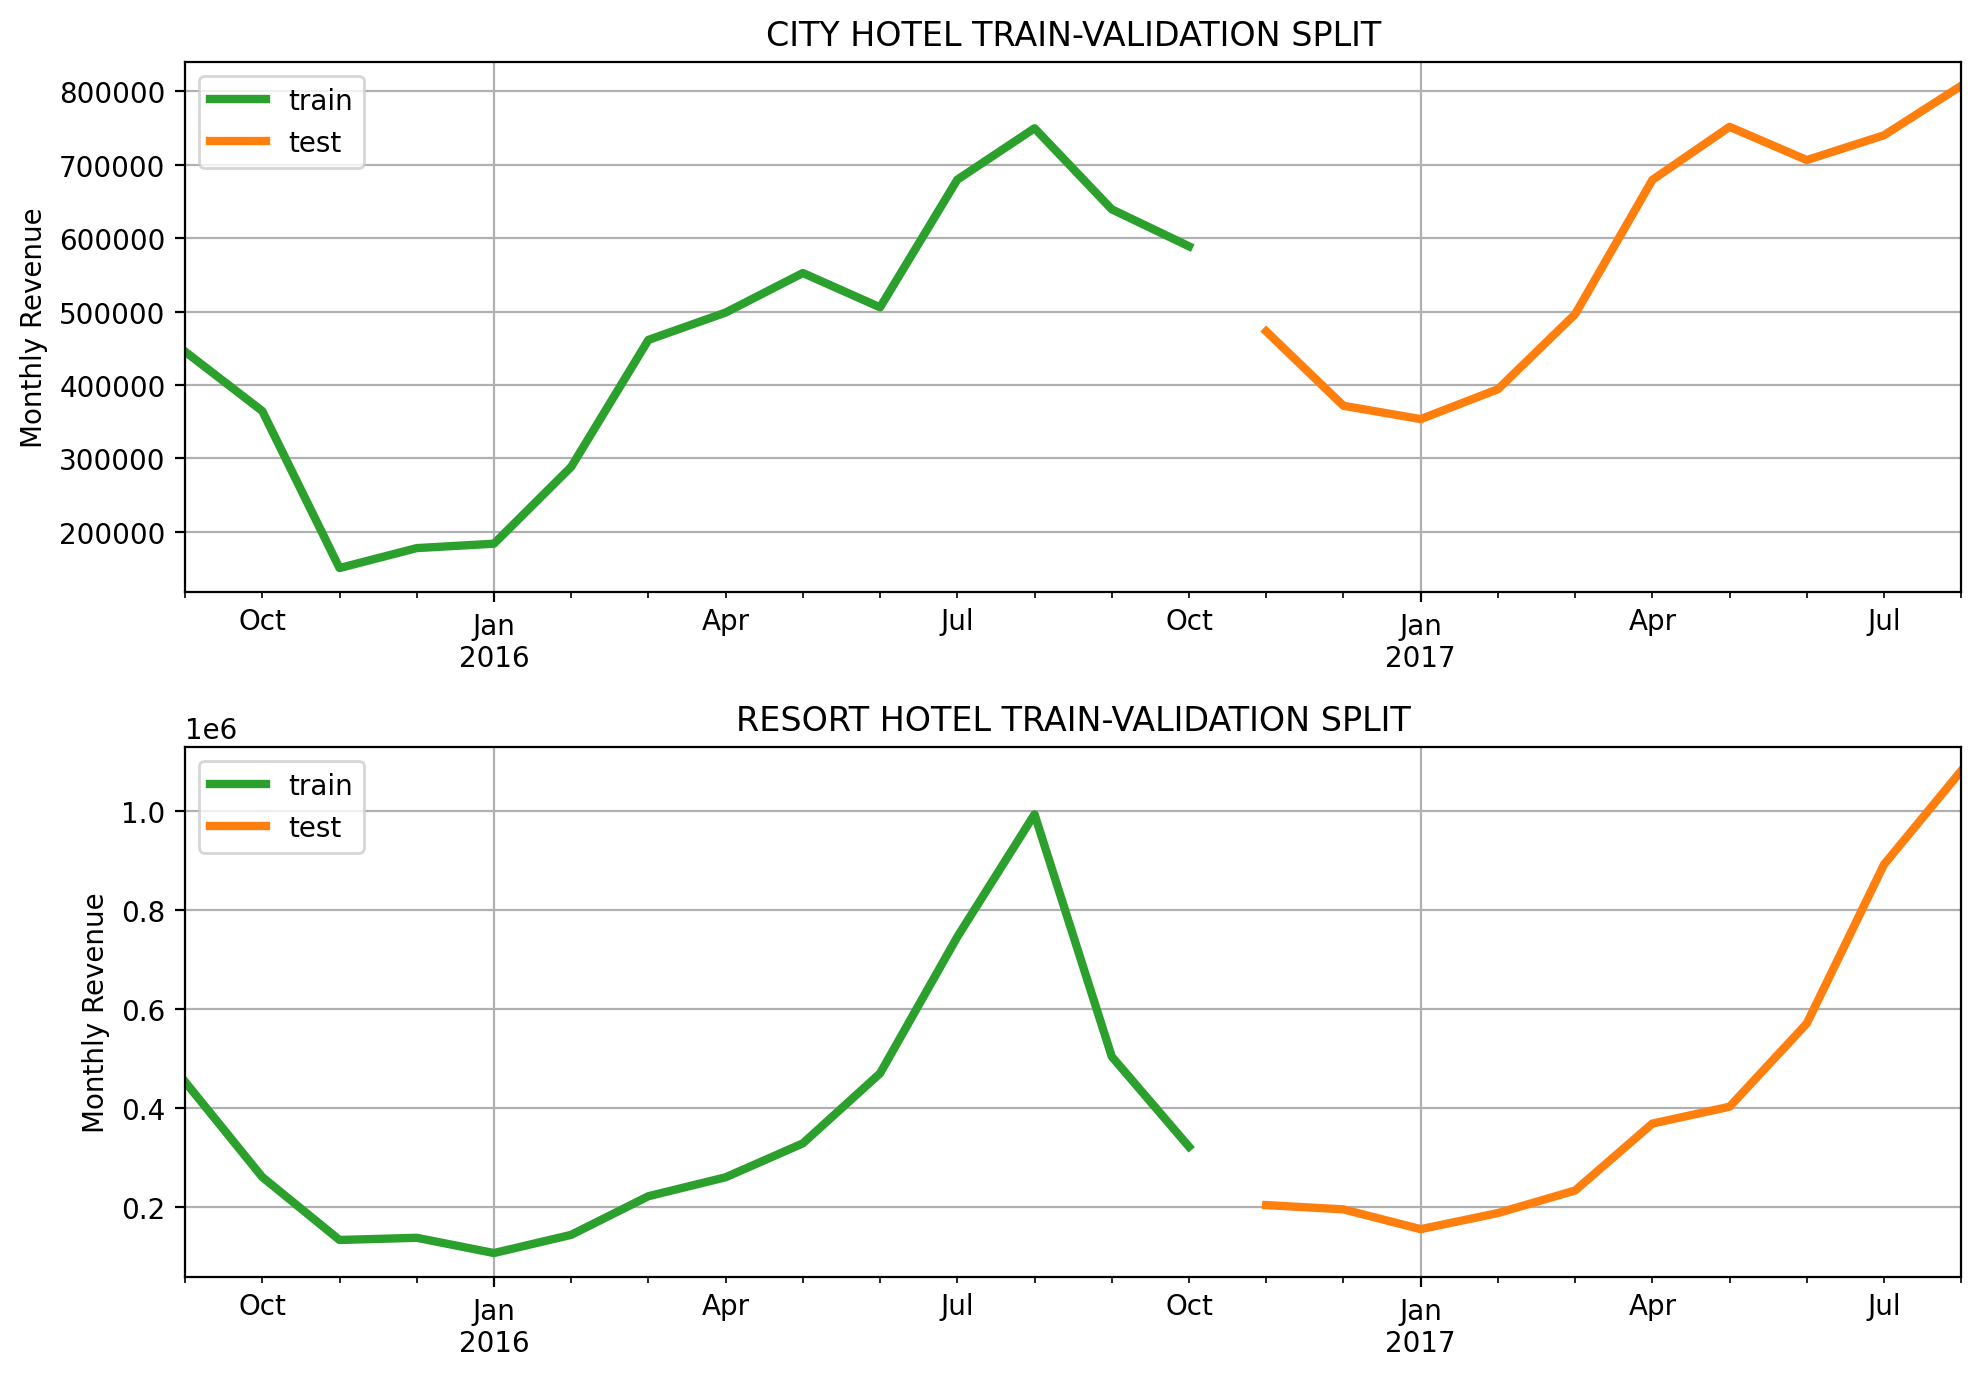

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
for hotel, ax in zip(HOTELS_LIST, axes):
    e.draw_train_test_predict(ax=ax,
                              train=train[hotel],
                              test=valid[hotel],
                              predict=None,
                              title=f"{hotel} train-validation split")
plt.tight_layout()
plt.show()

### Spline transformations encoding 

Let's encode the spline transformations for the month of the year, since this is a periodic feature associated with time.

In [48]:
EXOG_COLUMNS = ['spline1', 'spline2', 'spline3']

In [49]:
spline_transformer = m.periodic_spline_transformer(12, n_splines=3)
spline_transformer.fit(train[['month_of_the_year']])

SplineTransformer(extrapolation='periodic',
                  knots=array([[ 0.],
       [ 4.],
       [ 8.],
       [12.]]),
                  n_knots=4)

Save fitted transformer for use at inference stage.

In [50]:
u.save_pickle(obj=spline_transformer,
              path=u.get_abs_path(rel_path=MODELS_PATH,
                                  filename='spline_transformer.pkl'))

In [51]:
train = train.join(
    pd.DataFrame(spline_transformer.transform(train[['month_of_the_year']]),
                 index=train.index,
                 columns=EXOG_COLUMNS))

In [52]:
valid = valid.join(
    pd.DataFrame(spline_transformer.transform(valid[['month_of_the_year']]),
                 index=valid.index,
                 columns=EXOG_COLUMNS))

### Recursive multi-step forecasting

Create and train forecaster for both hotels

In [53]:
recursive_models = dict()

for hotel in HOTELS_LIST:
    recursive_models[hotel] = ForecasterAutoreg(
        regressor=Ridge(random_state=RANDOM_STATE),
        transformer_y=StandardScaler(),
        lags=N_LAGS)
    
    recursive_models[hotel].fit(y=train[hotel],
                                exog=train[EXOG_COLUMNS])
    print(f"{hotel}")
    print(recursive_models[hotel])
    print()

City Hotel
ForecasterAutoreg 
Regressor: Ridge(random_state=230220) 
Lags: [1 2] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 2 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['spline1', 'spline2', 'spline3'] 
Training range: [Timestamp('2015-09-30 00:00:00'), Timestamp('2016-10-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 230220, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-02-21 12:15:07 
Last fit date: 2023-02-21 12:15:07 
Skforecast version: 0.6.0 
Python version: 3.9.6 


Resort Hotel
ForecasterAutoreg 
Regressor: Ridge(random_state=230220) 
Lags: [1 2] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 2 
Weight funct

Let's inspect the data prepared by forecaster.

In [54]:
X, y = recursive_models['City Hotel'].create_train_X_y(
    train['City Hotel'], exog=train[EXOG_COLUMNS])
X['target'] = y
print(X.shape)
X.head()

(12, 6)


,lag_1,lag_2,spline1,spline2,spline3,target
2015-11-30,-0.455678,-0.018940,0.315104,0.611979,0.072917,-1.608563
2015-12-31,-1.608563,-0.455678,0.166667,0.666667,0.166667,-1.462121
2016-01-31,-1.462121,-1.608563,0.072917,0.611979,0.315104,-1.429831
2016-02-29,-1.429831,-1.462121,0.041667,0.479167,0.479167,-0.865770
2016-03-31,-0.865770,-1.429831,0.072917,0.315104,0.611979,0.066728


The structure is ok.

Now we can make a prediction for 6 stpes ahead and compare it with validation dataset.

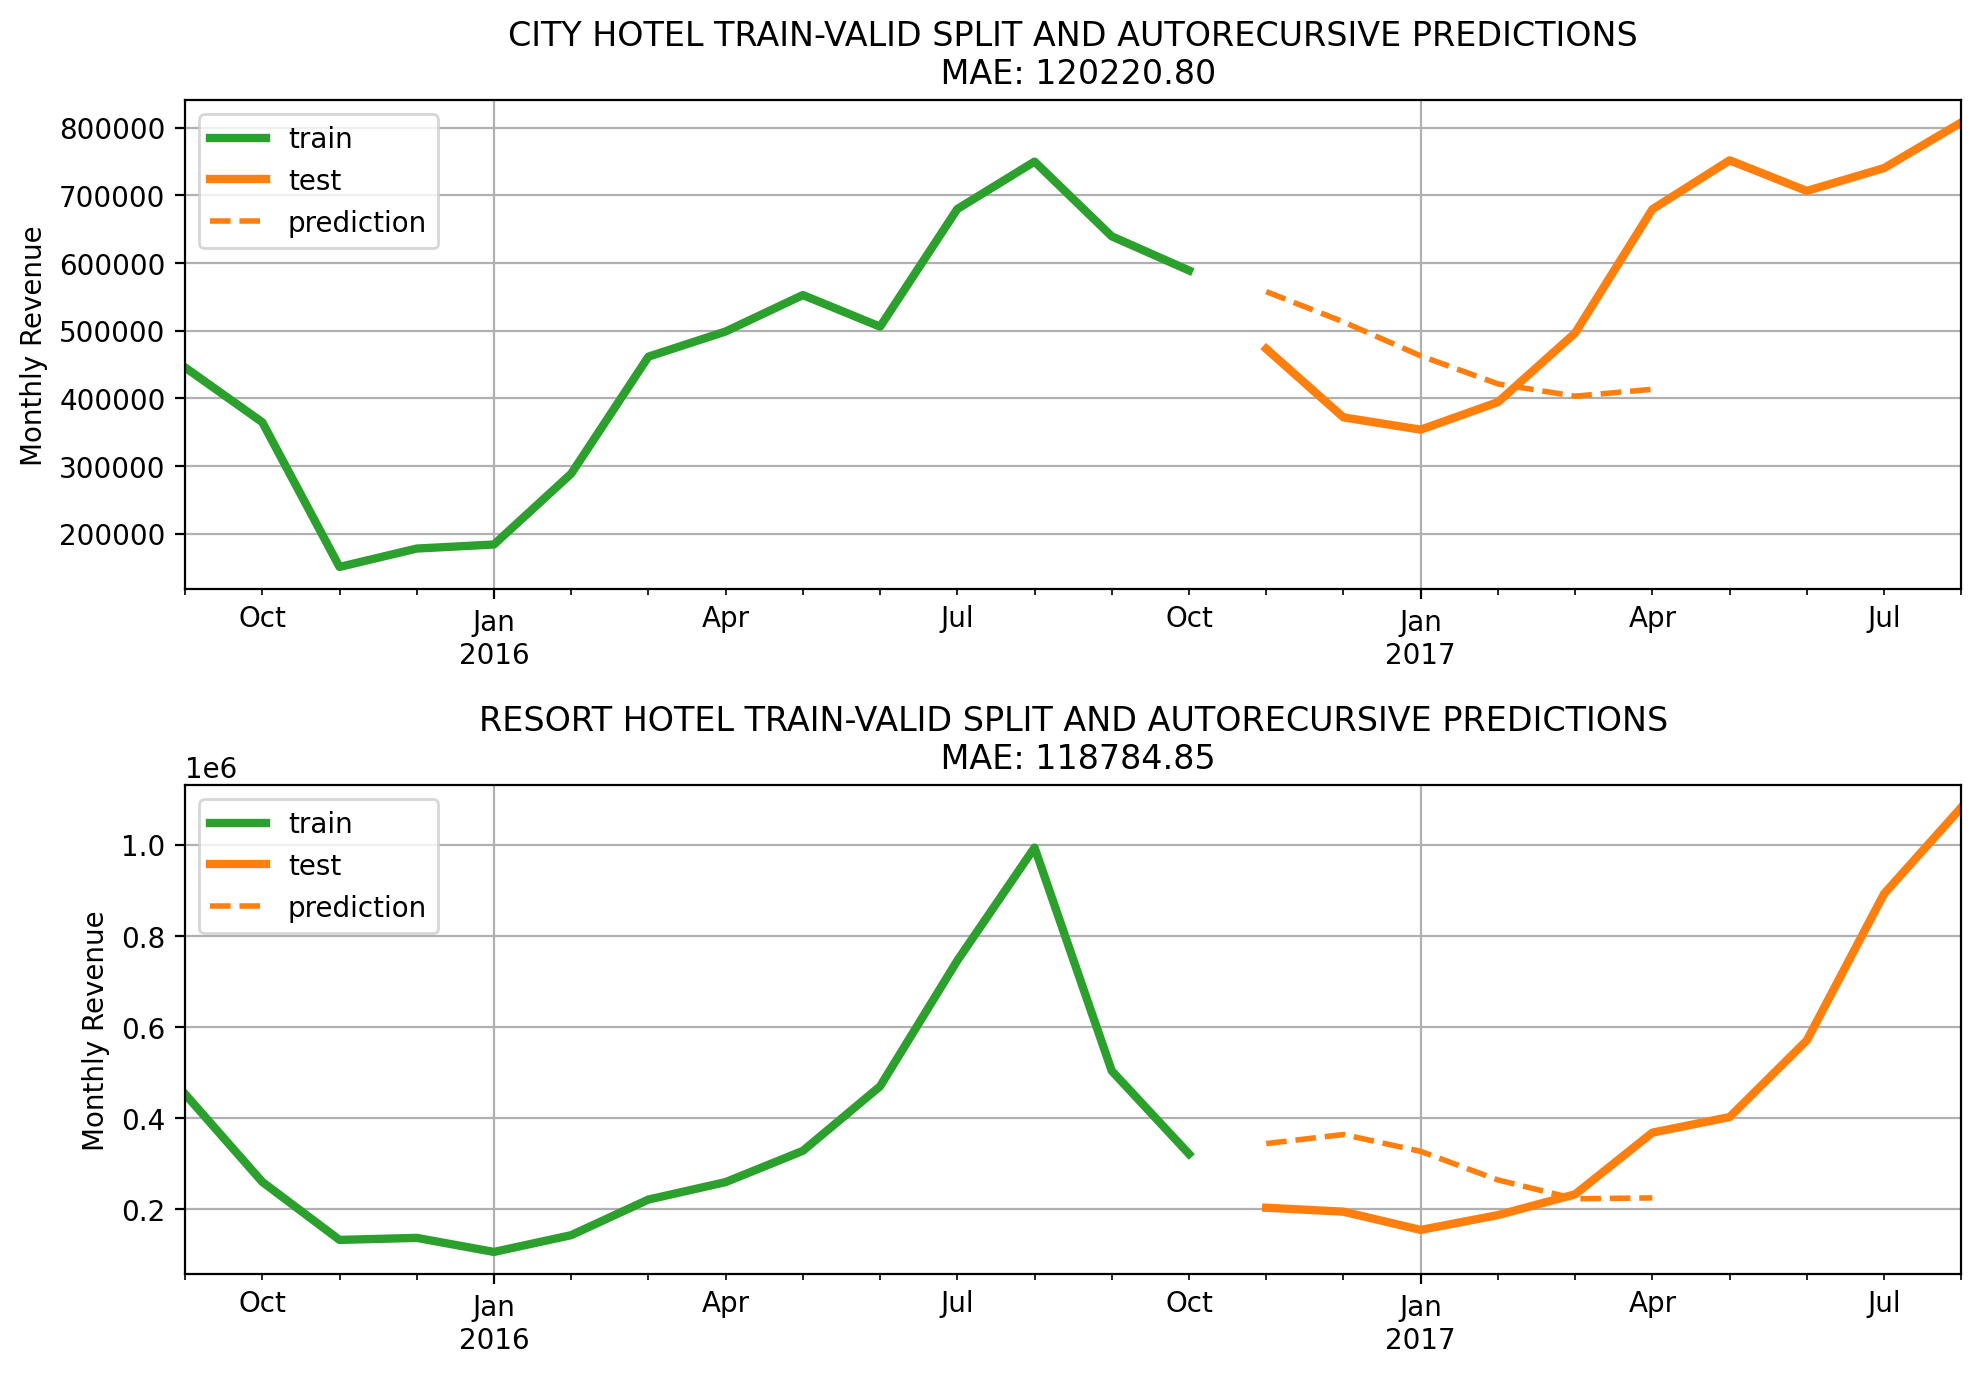

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))

for hotel, ax in zip(HOTELS_LIST, axes):
    predictions = recursive_models[hotel].predict(steps=N_STEPS,
                                                  exog=train[EXOG_COLUMNS])

    e.draw_train_test_predict(
        ax=ax,
        train=train[hotel],
        test=valid[hotel],
        predict=[predictions],
        title=f"{hotel} train-valid split and autorecursive predictions")
plt.tight_layout()
plt.show()

### Direct multi-step forecasting

Create and fit forecasters for each hotels

In [56]:
direct_models = dict()

for hotel in HOTELS_LIST:
    direct_models[hotel] = ForecasterAutoregDirect(
        regressor=Ridge(random_state=RANDOM_STATE),
        transformer_y=StandardScaler(),
        steps=N_STEPS,
        lags=N_LAGS)
    
    direct_models[hotel].fit(y=train[hotel],
                             exog=train[EXOG_COLUMNS])
    print(f"{hotel}")
    print(direct_models[hotel])
    print()

City Hotel
ForecasterAutoregDirect 
Regressor: Ridge(random_state=230220) 
Lags: [1 2] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Included weights function: False 
Window size: 2 
Maximum steps predicted: 6 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['spline1', 'spline2', 'spline3'] 
Training range: [Timestamp('2015-09-30 00:00:00'), Timestamp('2016-10-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 230220, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-02-21 12:15:08 
Last fit date: 2023-02-21 12:15:08 
Skforecast version: 0.6.0 
Python version: 3.9.6 


Resort Hotel
ForecasterAutoregDirect 
Regressor: Ridge(random_state=230220) 
Lags: [1 2] 
Transformer for y: 

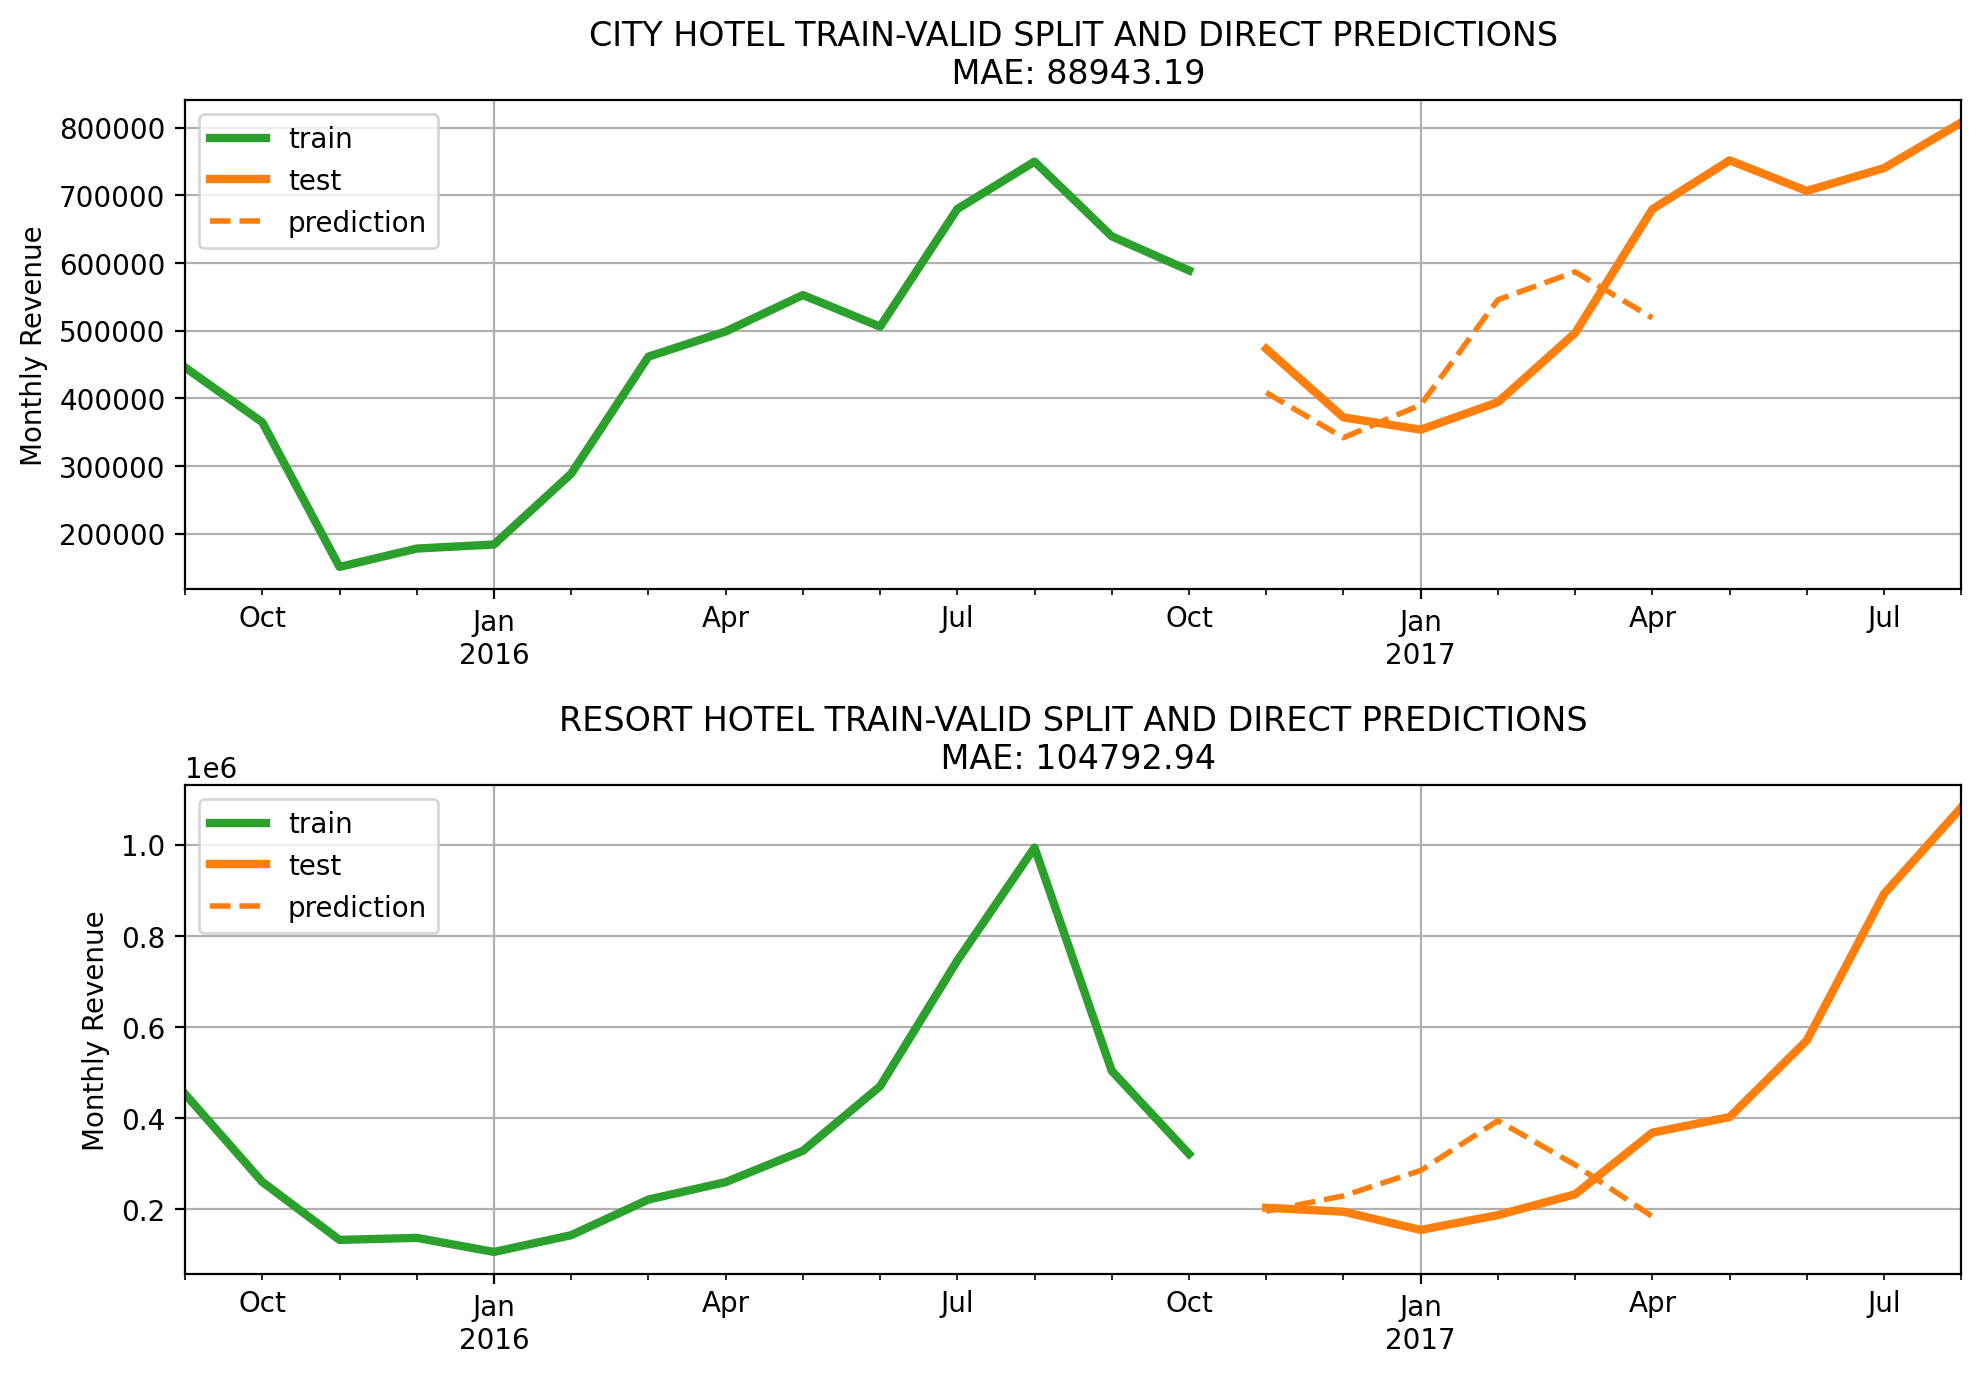

In [57]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
for hotel, ax in zip(HOTELS_LIST, axes):
    predictions = direct_models[hotel].predict(steps=N_STEPS,
                                               exog=train[EXOG_COLUMNS])

    e.draw_train_test_predict(
        ax=ax,
        train=train[hotel],
        test=valid[hotel],
        predict=[predictions],
        title=f"{hotel} train-valid split and direct predictions")
plt.tight_layout()
plt.show()

## Models performance evaluation

For each hotel and each model we run an evaluation using a sliding window approach on the validation data and store absolute errors and prediction of each run.

In [58]:
absolute_errors, valid_predictions = dict(), dict()

for hotel in HOTELS_LIST:
    for model, model_type in zip([recursive_models, direct_models],
                                 ['recursive', 'direct']):
        to_drop = set(HOTELS_LIST) - set([hotel])
        aes, preds = m.run_evaluation(train=train.drop(to_drop, axis=1),
                                      valid=valid.drop(to_drop, axis=1),
                                      series_column=hotel,
                                      model=model[hotel],
                                      n_tests=N_TESTS,
                                      n_lag=N_LAGS,
                                      n_steps=N_STEPS,
                                      exog=EXOG_COLUMNS)
        absolute_errors[f"{hotel}-{model_type}"] = aes
        valid_predictions[f"{hotel}-{model_type}"] = preds

Let's visualise predictions on validation dataset.

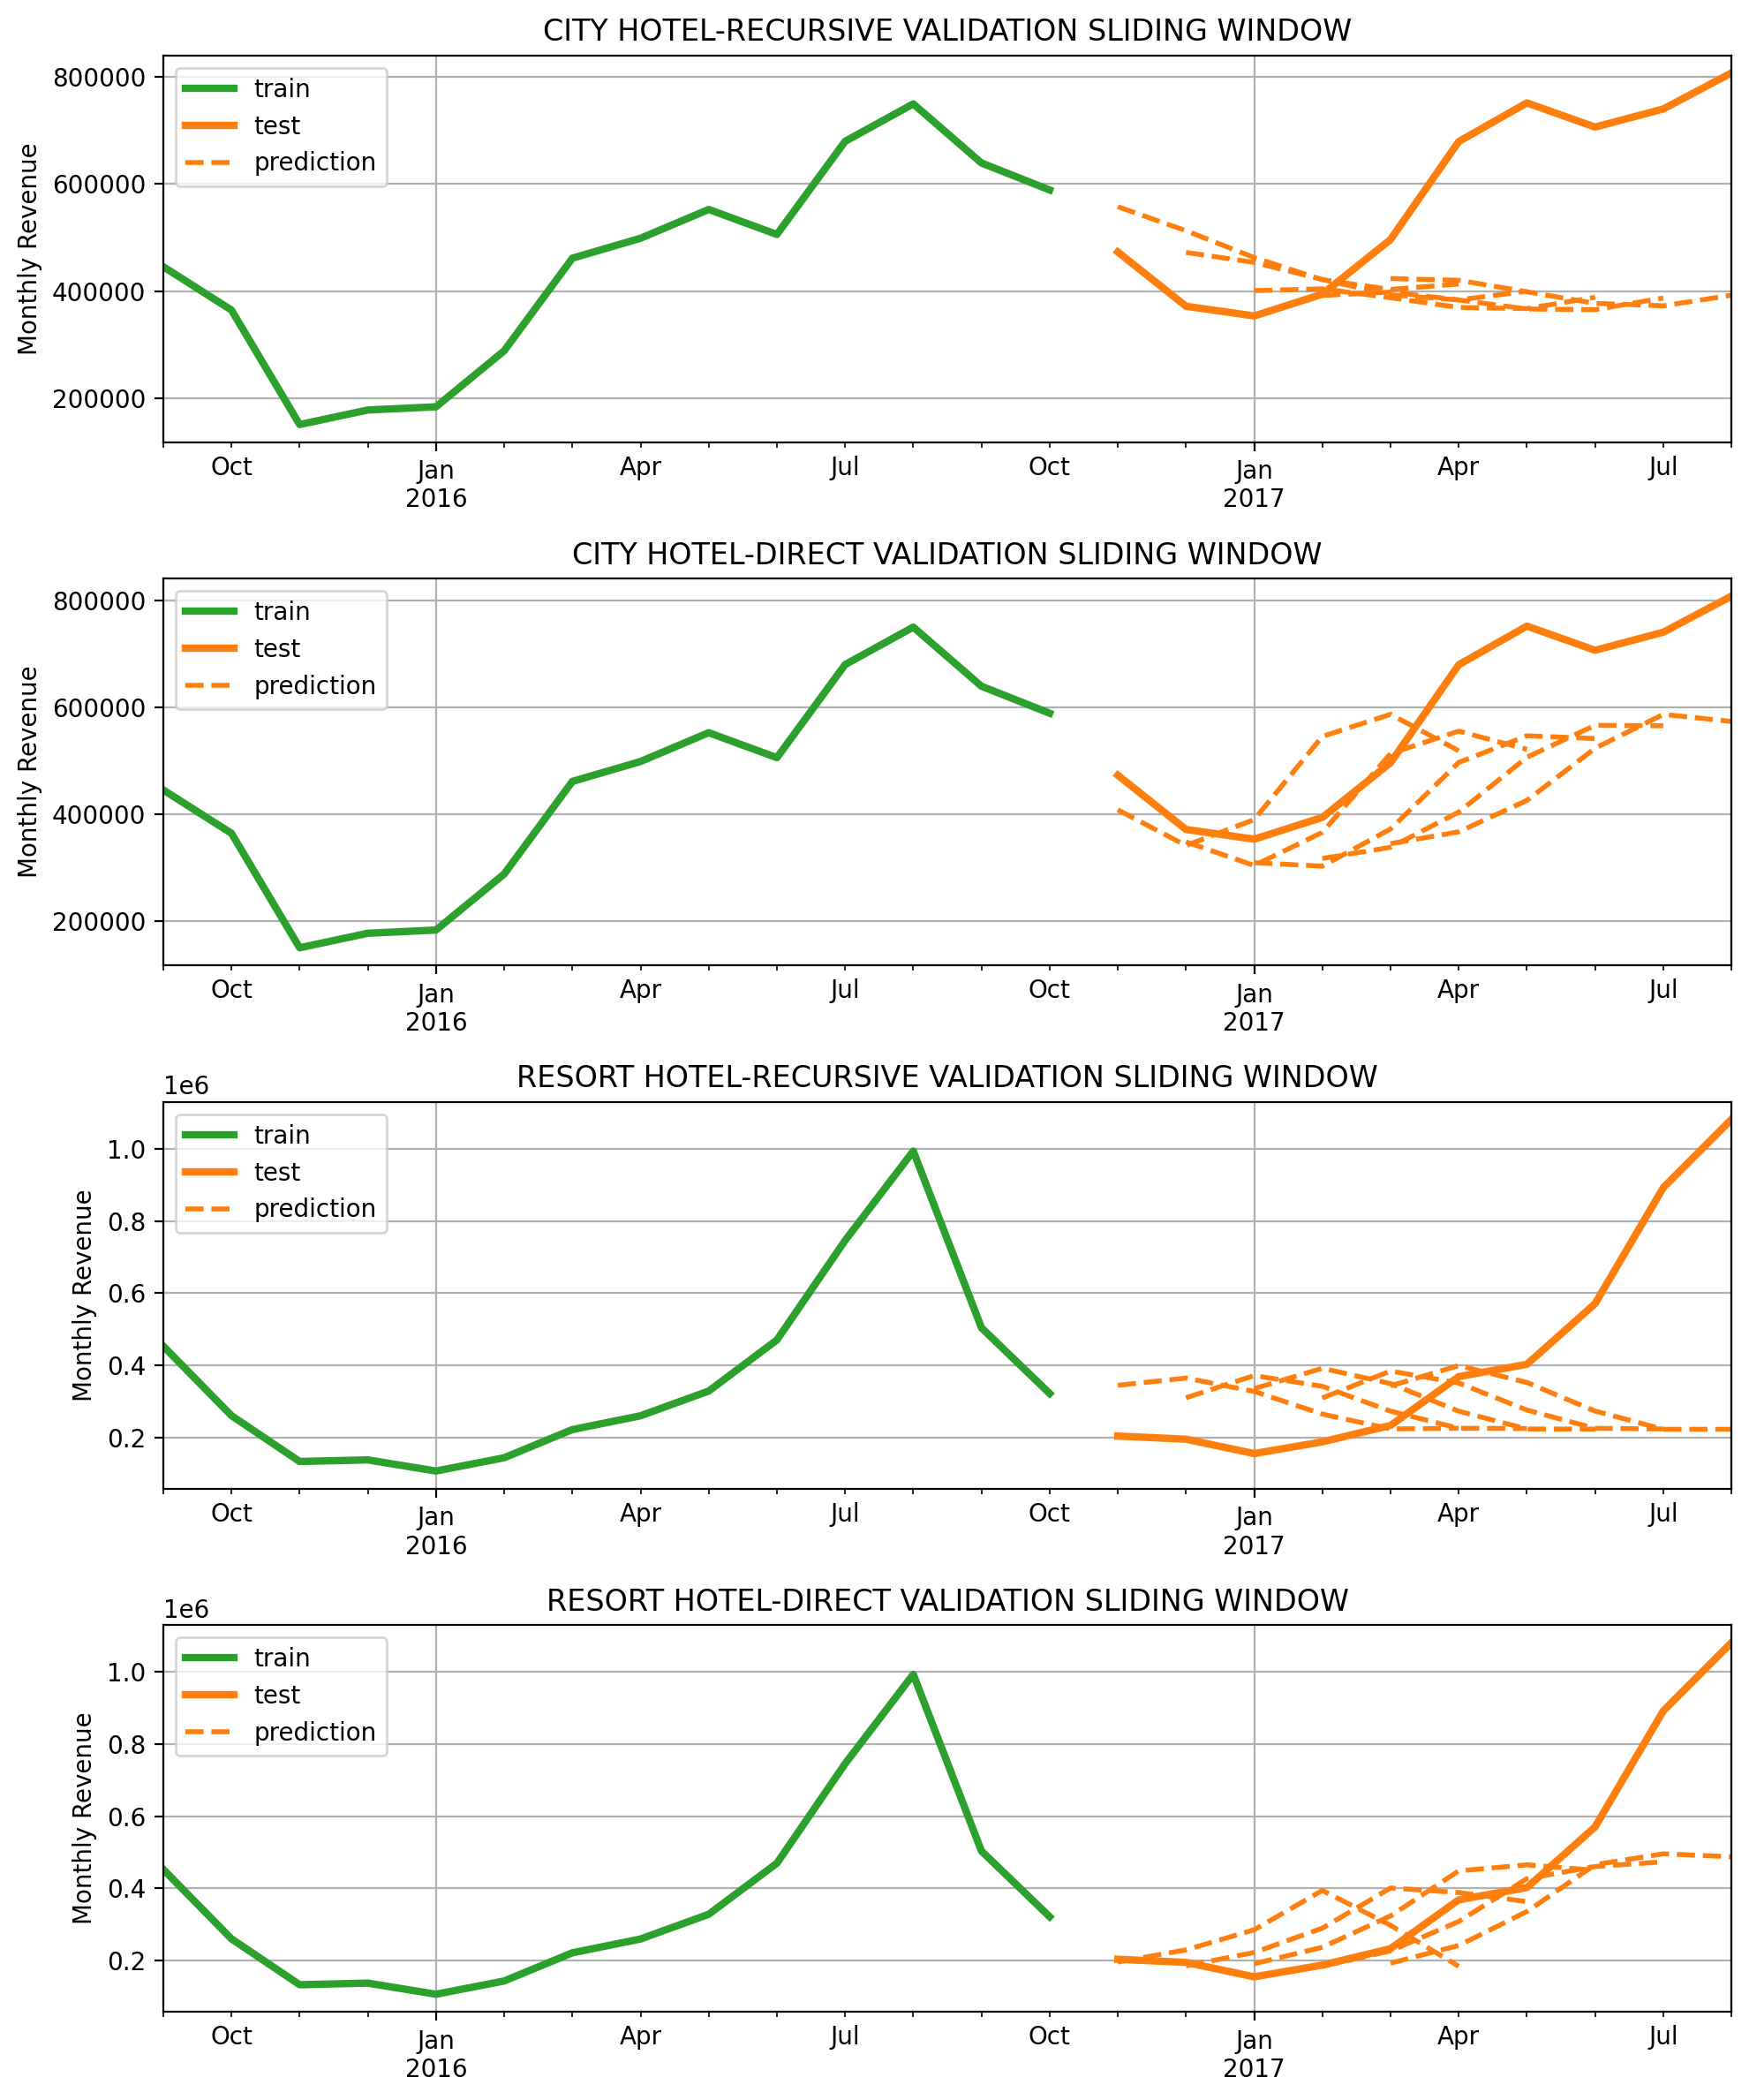

In [59]:
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

for i, hotel in enumerate(HOTELS_LIST):
    for j, (model, model_type) in enumerate(
            zip([recursive_models, direct_models], ['recursive', 'direct'])):

        e.draw_train_test_predict(
            ax=axes[i * 2 + j],
            train=train[hotel],
            test=valid[hotel],
            predict=valid_predictions[f"{hotel}-{model_type}"],
            title=f"{hotel}-{model_type} validation sliding window")
plt.tight_layout()
plt.show()

Finally, we calculate a performance score as MAE and its 95% confidence interval for each model in thousands.

In [60]:
(pd.DataFrame({ 
    'MAE, K': pd.DataFrame(absolute_errors).mean(),
    '2.5%': pd.DataFrame(absolute_errors).quantile(0.025),
    '97.5%': pd.DataFrame(absolute_errors).quantile(0.975)
}) / 1000).style.format(precision=2)


,"MAE, K",2.5%,97.5%
City Hotel-recursive,205.09,7.88,393.47
City Hotel-direct,141.54,21.51,315.84
Resort Hotel-recursive,204.42,15.66,722.07
Resort Hotel-direct,114.23,5.39,466.84


## Save models

In [61]:
for hotel in HOTELS_LIST:
    filename = u.get_abs_path(rel_path=MODELS_PATH, filename=f"{hotel.replace(' ', '')}.pkl")
    save_forecaster(direct_models[hotel], file_name=filename, verbose=False)

In [62]:
params = {
    'n_steps': N_STEPS,
    'n_lags': N_LAGS,
    'exog_columns': EXOG_COLUMNS,
    'models_path': MODELS_PATH
}

In [63]:
with open(os_path.join(u.get_project_dir(), "params.yaml"), "w") as f:
    yaml_dump(params, f)

## Conclusion

We investigated the data quality and identified several issues. Firstly, we discovered duplicate rows in the dataset, which we removed. We also deleted rows with negative and zero values of the ADR field, as well as those with an extreme value above 5000. Additionally, we noted that the number of records for the first two months of the time series was significantly lower than the corresponding period in the future, indicating incomplete data records for July and August 2015. We did not observe any other errors, and both hotels had the same range for their time series, from July 1st, 2015 to August 31st, 2017.

To calculate daily revenue and convert it to monthly revenue, we developed a function based on booking transaction history. After examining the monthly income time series for each hotel, we confirmed that the first two months of the series contained incomplete data. We also observed annual seasonality in the time series.

Due to the short historical timeframe concerning the number of prediction steps required, we skipped the last step of testing on the test dataset. Instead, we developed two independent models for each time series, reducing the problem of multi-series multi-step forecasting to multi-step forecasting only.

We compared two strategies for multi-step forecasting, namely recursing and direct ones, for each hotel. As a result, we developed four models and evaluated them on the validation dataset. 

The direct multi-step forecasting strategy showed the best results for both hotels, with 
- a MAE of 141.54K and a 95% confidence interval of 21.51K—315.84K for City Hotel, and 
- a MAE of 114.23K and a 95% confidence interval of 5.39K—466.84K for Resort Hotel.

